### Библиотеки

In [959]:
import logging

logger = logging.getLogger(__name__)
import sys

c_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(c_handler)
logging.basicConfig(level=logging.INFO, force=True)

import random
import warnings
from datetime import datetime
from typing import Any

import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
from chronos import BaseChronosPipeline
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from torch.nn import Module
from tqdm.notebook import tqdm

import tsururu.dataset
from tsururu.model_training.trainer import DLTrainer, MLTrainer
from tsururu.model_training.validator import KFoldCrossValidator, HoldOutValidator
from tsururu.models.boost import CatBoost, CatBoostRegressor
from tsururu.strategies import MIMOStrategy

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer

import statsforecast as stf
import statsforecast.models as stfm
from statsforecast import StatsForecast

import utilsforecast
import utilsforecast.losses
from utilsforecast.losses import mae, rmse, smape, mase, mape
from utilsforecast.evaluation import evaluate

import ta

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import EfficientFCParameters

import holidays

import optuna
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from catboost import CatBoostRegressor
from mlforecast import MLForecast
import pandas as pd
from tqdm import tqdm
import utilsforecast.losses
import catboost

from sklearn.ensemble import RandomForestRegressor

from neuralforecast import NeuralForecast
from neuralforecast.models import RNN
from neuralforecast.losses.pytorch import MQLoss, MASE
from neuralforecast.models import SOFTS
from neuralforecast.models import TimesNet
from neuralforecast.models import StemGNN

import sqlite3

warnings.filterwarnings("ignore")

### Читаем данные

In [973]:
with sqlite3.connect('moex_stock_price_prediction_service.db') as conn:
    df = pd.read_sql('SELECT * FROM clean_prices', conn,
                     parse_dates={"TRADEDATE": {"format": "%Y-%m-%d"}})


### Визуализация

In [975]:
cols_dct = {
    'CLOSE': 'Цены закрытия',
    # 'OPEN': 'Цены открытия',
    # 'WAPRICE': 'Средневзвешенная цена',
    # 'LOW': 'Минимальная цена',
    # 'HIGH': 'Максимальная цена',
    # 'VOLUME': 'Объем торгов',
}

for col_name, description in cols_dct.items():

    fig = px.line(
        df, 
        x='TRADEDATE', 
        y=col_name, 
        color='SECID', 
        title=description,
        labels={col_name: 'Значение', 'TRADEDATE': 'Дата', 'id': 'Категория'}
    )

    fig.update_layout(
        hovermode='x unified',
        legend_title_text='Номер ряда',
        xaxis_title='Дата',
        yaxis_title='Значение',
        template='plotly_white' 
    )

    fig.show()

### Выделение тренировочной, валидационной и тестовой выборок

Выделим на валидацию 14 дней, 1 день для тестирования финальной модели, остальное - трейн

In [976]:
TEST_DATASET_SIZE = 1
VAL_DATASET_SIZE = 14
TRAIN_DATASET_SIZE = df['TRADEDATE'].nunique() - TEST_DATASET_SIZE - VAL_DATASET_SIZE

### Бейзлайны

Попробуем различные статистические бейзлайны

**Будем подбирать бейзлайн следующим методом:**
- Выделяем валидационную выборку (14 дней)
- Обучаемся на всей информации, хотим прогнозировать значение цены на 1 шаг вперед
- Прогнозируем цену первого дня валидации, считаем метрики качества прогнозирования (MASE, MAPE, SMAPE)

- На следующем шаге в тренировочную выборку добавляем день из валидации и прогнозируем второй день валидации, так же считаем метрики

- Повторяем пока валидационная выборка не закончится

- Усредняем полученные метрики за VAL_SIZE дней

- Выбираем бейзлайн

In [977]:
# Выделяем без теста, чтобы не заглядывать
grouped_row_number = df.groupby('SECID').cumcount()

df_for_naive = df.loc[grouped_row_number < TRAIN_DATASET_SIZE + VAL_DATASET_SIZE, ['TRADEDATE', 'SECID', 'CLOSE']]

df_for_naive = df_for_naive.rename(columns={
    'TRADEDATE': 'ds',
    'SECID': 'unique_id',
    'CLOSE': 'y'
})

#### Прогноз на 1 день вперед

In [978]:
# Функция для подсчета метрики доли верных угадываний движения цены

def directional_accuracy(df_train, forecast, model_names, target_col='y', id_col='unique_id', date_col='ds'):
    last_train_target = df_train[df_train[date_col] == df_train[date_col].max()].reset_index(drop=True)[target_col]
    
    forecast_diffs = ((forecast[model_names] - np.array(last_train_target).reshape(-1, 1)) >= 0).astype(int)
    
    true_false_matrix = (forecast_diffs == np.array(forecast_diffs[target_col]).reshape(-1, 1)).astype(int)

    return true_false_matrix.set_index(forecast[id_col]).reset_index()

In [979]:
max_date_num_val = TRAIN_DATASET_SIZE + VAL_DATASET_SIZE

# Определяем размер валидационной выборки
VALIDATION_SIZE = 14
TEST_SIZE = 1  # прогноз на 1 шаг вперед

# Подготовка для хранения результатов всех 7 прогнозов
all_metrics = []

naive_forecasts = []

for val_day in tqdm(range(VALIDATION_SIZE)):
    # Определяем маски для текущего прогноза
    # Конец обучающей выборки сдвигается с каждой итерацией
    train_end = max_date_num_val - VALIDATION_SIZE + val_day
    
    train_mask = grouped_row_number < train_end
    test_mask = grouped_row_number == train_end  # только 1 день для тестирования
    
    # Датасеты для наивных прогнозов
    df_train_naive_current = df_for_naive[train_mask]
    df_test_naive_current = df_for_naive[test_mask]
    
    # Инициализируем модели для каждого прогноза
    models = [
        stfm.Naive(),
        stfm.AutoARIMA(),
        stfm.AutoCES(),
        stfm.AutoETS(),
        stfm.AutoRegressive(lags=list(range(1, 8))),
        stfm.RandomWalkWithDrift(),
        stfm.WindowAverage(window_size=2, alias='WindowAverage(2)'),
        stfm.WindowAverage(window_size=3, alias='WindowAverage(3)'),
        stfm.WindowAverage(window_size=4, alias='WindowAverage(4)'),
        stfm.WindowAverage(window_size=5, alias='WindowAverage(5)'),
        stfm.WindowAverage(window_size=6, alias='WindowAverage(6)'),
        stfm.WindowAverage(window_size=7, alias='WindowAverage(7)'),
        stfm.WindowAverage(window_size=14, alias='WindowAverage(14)'),
    ]
    
    sf = StatsForecast(
        models=models,
        freq='D'
    )
    
    # Делаем прогнозы на 1 шаг вперед
    forecast_current = sf.forecast(df=df_train_naive_current, h=TEST_SIZE)
    
    # Добавляем фактические значения
    forecast_current['y'] = df_test_naive_current['y'].reset_index(drop=True)
    forecast_current.loc[:, 'ds'] = df_test_naive_current['ds'].reset_index(drop=True)

    naive_forecasts.append(forecast_current)

    # Извлекаем имена моделей
    model_names = forecast_current.columns[2:]
    
    # Рассчитываем метрики для текущего прогноза
    mase_current = utilsforecast.losses.mase(
        df=forecast_current, 
        train_df=df_train_naive_current,
        models=model_names,
        seasonality=1,
    )
    
    mape_current = utilsforecast.losses.mape(
        df=forecast_current, 
        models=model_names,
    )
    
    smape_current = utilsforecast.losses.smape(
        df=forecast_current, 
        models=model_names,
    )

    directional_accuracy_current = directional_accuracy(
        df_train_naive_current, forecast_current, model_names
    )
    
    # Сохраняем метрики для текущего дня валидации
    day_metrics = pd.DataFrame(data={
        'MASE_mean': mase_current.iloc[:, 1:].mean(),
        'MAPE_mean': mape_current.iloc[:, 1:].mean(),
        'SMAPE_mean': smape_current.iloc[:, 1:].mean(),
        'Directional_Accuracy_mean': directional_accuracy_current.iloc[:, 1:].mean(),

        'MASE_median': mase_current.iloc[:, 1:].median(),
        'MAPE_median': mape_current.iloc[:, 1:].median(),
        'SMAPE_median': smape_current.iloc[:, 1:].median(),
        'Directional_Accuracy_median': directional_accuracy_current.iloc[:, 1:].median()
    })
    
    # Добавляем информацию о дне валидации
    day_metrics['validation_day'] = val_day + 1
    
    # Добавляем в общий список
    all_metrics.append(day_metrics)

# Объединяем все метрики
combined_metrics = pd.concat(all_metrics)

# Группируем и усредняем по моделям
avg_metrics = combined_metrics.groupby(combined_metrics.index).mean().drop('validation_day', axis=1)

# Сортируем по MASE
final_metrics = avg_metrics.sort_values(by='MASE_median')

# Выводим финальные усредненные метрики
final_metrics

100%|██████████| 14/14 [02:32<00:00, 10.89s/it]


MASE_mean  MAPE_mean  SMAPE_mean  \
y                   0.000000   0.000000    0.000000   
AutoARIMA           0.887251   0.014194    0.007080   
RWD                 0.882467   0.014074    0.007019   
Naive               0.883129   0.014119    0.007039   
AutoETS             0.885894   0.014173    0.007068   
CES                 0.908864   0.014511    0.007233   
AutoRegressive      0.917551   0.014782    0.007369   
WindowAverage(2)    1.049940   0.016748    0.008339   
WindowAverage(3)    1.183505   0.019035    0.009462   
WindowAverage(4)    1.284377   0.020791    0.010321   
WindowAverage(5)    1.364199   0.022275    0.011035   
WindowAverage(6)    1.424808   0.023368    0.011545   
WindowAverage(7)    1.468713   0.024129    0.011889   
WindowAverage(14)   1.713490   0.028568    0.013994   

                   Directional_Accuracy_mean  MASE_median  MAPE_median  \
y                                   1.000000     0.000000     0.000000   
AutoARIMA                           0.443182     0.707527     0.012067   
RWD                                 0.509740     0.707623     0.011901   
Naive                               0.426948     0.712339     0.011933   
AutoETS                             0.405844     0.714716     0.011920   
CES                                 0.485390     0.758950     0.012322   
AutoRegressive                      0.423701     0.763405     0.012482   
WindowAverage(2)                    0.428571     0.865799     0.014057   
WindowAverage(3)                    0.451299     0.997822     0.016812   
WindowAverage(4)                    0.459416     1.090919     0.018399   
WindowAverage(5)                    0.501623     1.152022     0.019888   
WindowAverage(6)                    0.524351     1.190863     0.021308   
WindowAverage(7)                    0.548701     1.235269     0.021859   
WindowAverage(14)                   0.538961     1.454360     0.026854   

                   SMAPE_median  Directional_Accuracy_median  
y                      0.000000                     1.000000  
AutoARIMA              0.006022                     0.321429  
RWD                    0.005945                     0.535714  
Naive                  0.005957                     0.392857  
AutoETS                0.005953                     0.285714  
CES                    0.006152                     0.464286  
AutoRegressive         0.006233                     0.357143  
WindowAverage(2)       0.007021                     0.392857  
WindowAverage(3)       0.008389                     0.357143  
WindowAverage(4)       0.009180                     0.428571  
WindowAverage(5)       0.009906                     0.500000  
WindowAverage(6)       0.010587                     0.500000  
WindowAverage(7)       0.010831                     0.500000  
WindowAverage(14)      0.013244                     0.535714

In [980]:
naive_forecasts_df = pd.concat(naive_forecasts)

baseline_models = final_metrics.index

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = naive_forecasts_df[naive_forecasts_df['unique_id'] == ticker]

    for model in baseline_models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model} (MASE_median: {final_metrics.loc[model, "MASE_median"] :.2f})'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

##### Выбор модели бейзлайна

Лучше всех себя показала CES. Возьмем ее за бейзлайн.

### Признаки

#### Лаговые признаки

In [981]:
lag_features = []

for lag_num in range(1, 8):
    df[f'lag{lag_num}_CLOSE'] = df.groupby('SECID')['CLOSE'].shift(lag_num)
    lag_features.append(f'lag{lag_num}_CLOSE')

display(df)

print(f'Добавлены признаки: {lag_features}')

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
0     2022-04-01  AFKS    14.473    14.380    13.890    13.890    14.880   
1     2022-04-04  AFKS    14.105    14.057    14.105    13.501    14.499   
2     2022-04-05  AFKS    13.606    14.200    13.451    12.756    14.272   
3     2022-04-06  AFKS    13.474    13.160    13.493    12.856    13.923   
4     2022-04-07  AFKS    13.699    13.300    13.622    13.273    14.095   
...          ...   ...       ...       ...       ...       ...       ...   
35195 2025-05-21  YDEX  4009.000  4042.000  3990.500  3971.000  4050.000   
35196 2025-05-22  YDEX  3997.500  3980.500  4024.000  3925.000  4089.000   
35197 2025-05-23  YDEX  4016.500  4029.500  4009.500  3996.000  4048.000   
35198 2025-05-26  YDEX  3934.000  4004.000  3917.000  3886.000  4024.000   
35199 2025-05-27  YDEX  3969.500  3917.000  3992.500  3855.000  4024.000   

           VOLUME  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  lag4_CLOSE  lag5_CLOSE  \
0      59304300.0         NaN         NaN         NaN         NaN         NaN   
1      40030900.0      13.890         NaN         NaN         NaN         NaN   
2      25206000.0      14.105      13.890         NaN         NaN         NaN   
3      14170100.0      13.451      14.105      13.890         NaN         NaN   
4      15927000.0      13.493      13.451      14.105       13.89         NaN   
...           ...         ...         ...         ...         ...         ...   
35195    308142.0    4040.500    4054.000    4022.000     3989.50      4021.0   
35196    773529.0    3990.500    4040.500    4054.000     4022.00      3989.5   
35197    335528.0    4024.000    3990.500    4040.500     4054.00      4022.0   
35198    505249.0    4009.500    4024.000    3990.500     4040.50      4054.0   
35199    694981.0    3917.000    4009.500    4024.000     3990.50      4040.5   

       lag6_CLOSE  lag7_CLOSE  
0             NaN         NaN  
1             NaN         NaN  
2             NaN         NaN  
3             NaN         NaN  
4             NaN         NaN  
...           ...         ...  
35195      4114.5      4153.5  
35196      4021.0      4114.5  
35197      3989.5      4021.0  
35198      4022.0      3989.5  
35199      4054.0      4022.0  

[35200 rows x 15 columns]

Добавлены признаки: ['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE']


#### Признаки для дат

In [982]:
date_features = []

# Праздники
ru_holidays = holidays.country_holidays(
    'RU',
    years=range(2022, 2026)
)


df['weekend_flg'] = (df['TRADEDATE'].apply(lambda x: x.weekday()) >= 5).astype(int)
date_features.append('weekend_flg')

df['is_month_end'] = df['TRADEDATE'].apply(lambda x: x.is_month_end).astype(int)
date_features.append('is_month_end')

df['is_month_start'] = df['TRADEDATE'].apply(lambda x: x.is_month_start).astype(int)
date_features.append('is_month_start')

df['is_quarter_end'] = df['TRADEDATE'].apply(lambda x: x.is_quarter_end).astype(int)
date_features.append('is_quarter_end')
df['is_quarter_start'] = df['TRADEDATE'].apply(lambda x: x.is_quarter_start).astype(int)
date_features.append('is_quarter_start')


df['is_holiday_in_russia'] = df['TRADEDATE'].apply(lambda x: x.date() in ru_holidays).astype(int)
date_features.append('is_holiday_in_russia')

df['pre_holiday_in_russa'] = df['TRADEDATE'].shift(-1).isin(ru_holidays).astype(int)
date_features.append('pre_holiday_in_russa')

df['after_holiday_in_russa'] = df['TRADEDATE'].shift(1).isin(ru_holidays).astype(int)
date_features.append('after_holiday_in_russa')


df['weekday'] = df['TRADEDATE'].apply(lambda x: x.weekday())
date_features.append('weekday')

df['month'] = df['TRADEDATE'].apply(lambda x: x.month)
date_features.append('month')

df['quart'] = df['TRADEDATE'].apply(lambda x: x.quarter)
date_features.append('quart')

display(df)

print(f'Добавлены признаки: {date_features}')

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
0     2022-04-01  AFKS    14.473    14.380    13.890    13.890    14.880   
1     2022-04-04  AFKS    14.105    14.057    14.105    13.501    14.499   
2     2022-04-05  AFKS    13.606    14.200    13.451    12.756    14.272   
3     2022-04-06  AFKS    13.474    13.160    13.493    12.856    13.923   
4     2022-04-07  AFKS    13.699    13.300    13.622    13.273    14.095   
...          ...   ...       ...       ...       ...       ...       ...   
35195 2025-05-21  YDEX  4009.000  4042.000  3990.500  3971.000  4050.000   
35196 2025-05-22  YDEX  3997.500  3980.500  4024.000  3925.000  4089.000   
35197 2025-05-23  YDEX  4016.500  4029.500  4009.500  3996.000  4048.000   
35198 2025-05-26  YDEX  3934.000  4004.000  3917.000  3886.000  4024.000   
35199 2025-05-27  YDEX  3969.500  3917.000  3992.500  3855.000  4024.000   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  is_month_end  is_month_start  \
0      59304300.0         NaN         NaN  ...             0               1   
1      40030900.0      13.890         NaN  ...             0               0   
2      25206000.0      14.105      13.890  ...             0               0   
3      14170100.0      13.451      14.105  ...             0               0   
4      15927000.0      13.493      13.451  ...             0               0   
...           ...         ...         ...  ...           ...             ...   
35195    308142.0    4040.500    4054.000  ...             0               0   
35196    773529.0    3990.500    4040.500  ...             0               0   
35197    335528.0    4024.000    3990.500  ...             0               0   
35198    505249.0    4009.500    4024.000  ...             0               0   
35199    694981.0    3917.000    4009.500  ...             0               0   

       is_quarter_end  is_quarter_start  is_holiday_in_russia  \
0                   0                 1                     0   
1                   0                 0                     0   
2                   0                 0                     0   
3                   0                 0                     0   
4                   0                 0                     0   
...               ...               ...                   ...   
35195               0                 0                     0   
35196               0                 0                     0   
35197               0                 0                     0   
35198               0                 0                     0   
35199               0                 0                     0   

       pre_holiday_in_russa  after_holiday_in_russa  weekday  month  quart  
0                         0                       0        4      4      2  
1                         0                       0        0      4      2  
2                         0                       0        1      4      2  
3                         0                       0        2      4      2  
4                         0                       0        3      4      2  
...                     ...                     ...      ...    ...    ...  
35195                     0                       0        2      5      2  
35196                     0                       0        3      5      2  
35197                     0                       0        4      5      2  
35198                     0                       0        0      5      2  
35199                     0                       0        1      5      2  

[35200 rows x 26 columns]

Добавлены признаки: ['weekend_flg', 'is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_holiday_in_russia', 'pre_holiday_in_russa', 'after_holiday_in_russa', 'weekday', 'month', 'quart']


#### Признаки на основе выплаты дивидендов (to be done)

#### Признаки для технического анализа (ta)

In [983]:
tech_analysis_features = []

# Сортируем данные по тикеру и дате
df = df.sort_values(by=['SECID', 'TRADEDATE'])

# Функция для расчета всех индикаторов в группе
def calculate_ta_indicators(group):
    # RSI
    rsi_indicator = ta.momentum.RSIIndicator(close=group['CLOSE'], window=14)
    group['rsi'] = rsi_indicator.rsi()
    
    # MACD
    macd_indicator = ta.trend.MACD(
        close=group['CLOSE'], 
        window_slow=26, 
        window_fast=12, 
        window_sign=9
    )
    group['macd'] = macd_indicator.macd()
    
    # Скользящие средние
    group['moving_average_short'] = group['CLOSE'].rolling(window=20).mean()
    group['moving_average_long'] = group['CLOSE'].rolling(window=50).mean()
    
    # Полосы Боллинджера
    bollinger = ta.volatility.BollingerBands(close=group['CLOSE'], window=20, window_dev=2)
    group['bollinger_upper'] = bollinger.bollinger_hband()
    group['bollinger_lower'] = bollinger.bollinger_lband()
    
    # Стохастический осциллятор
    stoch = ta.momentum.StochasticOscillator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14, 
        smooth_window=3
    )
    group['stoch_k'] = stoch.stoch()
    group['stoch_d'] = stoch.stoch_signal()
    
    # ATR
    atr = ta.volatility.AverageTrueRange(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14
    )
    group['atr'] = atr.average_true_range()
    
    # ADX
    adx = ta.trend.ADXIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14
    )
    group['adx'] = adx.adx()
    
    # Williams %R
    williams_r = ta.momentum.WilliamsRIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        lbp=14
    )
    group['williams_r'] = williams_r.williams_r()
    
    # CCI
    cci = ta.trend.CCIIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=20
    )
    group['cci'] = cci.cci()
    
    return group

# Применяем расчеты к каждой группе отдельно
df = df.groupby('SECID', group_keys=False).apply(calculate_ta_indicators)

tech_analysis_features = [
    'rsi', 'macd', 'moving_average_short', 'moving_average_long',
    'bollinger_upper', 'bollinger_lower', 'stoch_k', 'stoch_d',
    'atr', 'adx', 'williams_r', 'cci'
]

display(df)
print(f'Добавлены признаки: {tech_analysis_features}')


TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
0     2022-04-01  AFKS    14.473    14.380    13.890    13.890    14.880   
1     2022-04-04  AFKS    14.105    14.057    14.105    13.501    14.499   
2     2022-04-05  AFKS    13.606    14.200    13.451    12.756    14.272   
3     2022-04-06  AFKS    13.474    13.160    13.493    12.856    13.923   
4     2022-04-07  AFKS    13.699    13.300    13.622    13.273    14.095   
...          ...   ...       ...       ...       ...       ...       ...   
35195 2025-05-21  YDEX  4009.000  4042.000  3990.500  3971.000  4050.000   
35196 2025-05-22  YDEX  3997.500  3980.500  4024.000  3925.000  4089.000   
35197 2025-05-23  YDEX  4016.500  4029.500  4009.500  3996.000  4048.000   
35198 2025-05-26  YDEX  3934.000  4004.000  3917.000  3886.000  4024.000   
35199 2025-05-27  YDEX  3969.500  3917.000  3992.500  3855.000  4024.000   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  moving_average_short  \
0      59304300.0         NaN         NaN  ...                   NaN   
1      40030900.0      13.890         NaN  ...                   NaN   
2      25206000.0      14.105      13.890  ...                   NaN   
3      14170100.0      13.451      14.105  ...                   NaN   
4      15927000.0      13.493      13.451  ...                   NaN   
...           ...         ...         ...  ...                   ...   
35195    308142.0    4040.500    4054.000  ...              4100.225   
35196    773529.0    3990.500    4040.500  ...              4083.300   
35197    335528.0    4024.000    3990.500  ...              4069.525   
35198    505249.0    4009.500    4024.000  ...              4050.725   
35199    694981.0    3917.000    4009.500  ...              4031.775   

       moving_average_long  bollinger_upper  bollinger_lower    stoch_k  \
0                      NaN              NaN              NaN        NaN   
1                      NaN              NaN              NaN        NaN   
2                      NaN              NaN              NaN        NaN   
3                      NaN              NaN              NaN        NaN   
4                      NaN              NaN              NaN        NaN   
...                    ...              ...              ...        ...   
35195              4264.83      4390.782477      3809.667523  44.458438   
35196              4254.02      4349.161317      3817.438683  55.851064   
35197              4243.63      4320.275768      3818.774232  51.994681   
35198              4232.37      4287.635843      3813.814157  26.809651   
35199              4221.68      4218.293223      3845.256777  41.044776   

         stoch_d         atr        adx  williams_r        cci  
0            NaN    0.000000   0.000000         NaN        NaN  
1            NaN    0.000000   0.000000         NaN        NaN  
2            NaN    0.000000   0.000000         NaN        NaN  
3            NaN    0.000000   0.000000         NaN        NaN  
4            NaN    0.000000   0.000000         NaN        NaN  
...          ...         ...        ...         ...        ...  
35195  44.550237  142.320502  27.381767  -55.541562 -59.682512  
35196  48.461376  143.869037  27.610998  -44.148936 -49.657297  
35197  50.768061  137.306963  27.823856  -48.005319 -41.886977  
35198  44.885132  137.356466  28.727334  -73.190349 -92.615381  
35199  39.949703  139.616718  29.742388  -58.955224 -78.458925  

[35200 rows x 38 columns]

Добавлены признаки: ['rsi', 'macd', 'moving_average_short', 'moving_average_long', 'bollinger_upper', 'bollinger_lower', 'stoch_k', 'stoch_d', 'atr', 'adx', 'williams_r', 'cci']


#### Статистические признаки (tsfresh) - Очень много и нет доверия

In [808]:
# df_rolled = roll_time_series(df, column_id="SECID", column_sort="TRADEDATE",
#                              max_timeshift=20, min_timeshift=5)

In [809]:
# X = extract_features(df_rolled.drop(columns=["SECID", 'WAPRICE', 'OPEN', 'LOW', 'HIGH', 'VOLUME'], axis=1), 
#                      column_id="id", column_sort="TRADEDATE", column_value="CLOSE", 
#                      impute_function=impute, show_warnings=False)

In [810]:
# X = X.reset_index().rename(columns={
#     'level_0': 'SECID',
#     'level_1': 'TRADEDATE'
#     })
# X

In [811]:
# # TEST_SIZE = 1

# df_for_split = df[df['TRADEDATE'] >= min(X['TRADEDATE'])].reset_index(drop=True).sort_values(by=['SECID', 'TRADEDATE'])

# grouped_row_number = X.groupby('SECID').cumcount()
# max_date_num = max(grouped_row_number)

# train_mask = grouped_row_number <= (max_date_num - VAL_DATASET_SIZE - TEST_DATASET_SIZE)
# val_mask = ((max_date_num - VAL_DATASET_SIZE - TEST_SIZE) < grouped_row_number) & (grouped_row_number <= (max_date_num - TEST_DATASET_SIZE))
# test_mask = grouped_row_number > (max_date_num - TEST_DATASET_SIZE)

# # датасеты для всех прогнозов
# X_train = X[train_mask].reset_index(drop=True)
# y_train = df_for_split['CLOSE'][train_mask].reset_index(drop=True)

# X_val = X[val_mask].reset_index(drop=True)
# y_val = df_for_split['CLOSE'][val_mask].reset_index(drop=True)

# X_test = X[test_mask].reset_index(drop=True)
# y_test = df_for_split['CLOSE'][test_mask].reset_index(drop=True)

In [812]:
# X_train_selected = select_features(X_train.drop(columns=['SECID', 'TRADEDATE']), 
#                                    y_train,
#                                    fdr_level=0.01)
# print(f'Осталось {X_train_selected.shape[1]} статистических признаков')

In [813]:
# tsfresh_features = list(X_train_selected.columns)
# print(f'Отобрали признаки: {tsfresh_features}')

In [814]:
# X_train = pd.concat([X_train.loc[:, ['SECID', 'TRADEDATE']], X_train_selected], axis=1)

In [815]:
# X_test = X_test.loc[:, X_train.columns]

#### Объединяем признаки в один датасет

In [816]:
# df_for_uniting_features = df[df['TRADEDATE'] >= min(X['TRADEDATE'])].sort_values(by=['SECID', 'TRADEDATE']).reset_index(drop=True)
# df_for_uniting_features

In [817]:
# X_train_united = pd.concat([X_train, df_for_uniting_features.drop(columns=['TRADEDATE',	'SECID', 'WAPRICE',	'OPEN', 'CLOSE', 'LOW',	'HIGH',	'VOLUME'])],
#                            axis=1).loc[X_train.index]

In [818]:
# X_test_united = pd.concat([X_test, df_for_uniting_features.drop(columns=['TRADEDATE', 'SECID', 'WAPRICE', 'OPEN', 'CLOSE', 'LOW', 'HIGH', 'VOLUME'])],
#                            axis=1).loc[X_test.index]

In [819]:
# print(X_train_united.shape)
# print(X_test_united.shape)

##### Выделяем таргет

In [820]:
# df['target'] = df.groupby('SECID')['CLOSE'].shift(-1)
# df

##### Чистим от пропусков

In [984]:
print(df[df['SECID'] == 'AFKS'].isna().sum())
print()
print(df[df['SECID'] == 'AFLT'].isna().sum())

TRADEDATE                  0
SECID                      0
WAPRICE                    0
OPEN                       0
CLOSE                      0
LOW                        0
HIGH                       0
VOLUME                     0
lag1_CLOSE                 1
lag2_CLOSE                 2
lag3_CLOSE                 3
lag4_CLOSE                 4
lag5_CLOSE                 5
lag6_CLOSE                 6
lag7_CLOSE                 7
weekend_flg                0
is_month_end               0
is_month_start             0
is_quarter_end             0
is_quarter_start           0
is_holiday_in_russia       0
pre_holiday_in_russa       0
after_holiday_in_russa     0
weekday                    0
month                      0
quart                      0
rsi                       13
macd                      25
moving_average_short      19
moving_average_long       49
bollinger_upper           19
bollinger_lower           19
stoch_k                   13
stoch_d                   15
atr           

In [985]:
df = df.dropna()
df

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
49    2022-06-16  AFKS    12.601    12.510    12.695    12.441    12.748   
50    2022-06-17  AFKS    12.611    12.700    12.508    12.508    12.741   
51    2022-06-20  AFKS    12.833    12.549    12.830    12.522    13.000   
52    2022-06-21  AFKS    12.904    12.990    12.972    12.760    12.990   
53    2022-06-22  AFKS    12.767    12.975    12.900    12.620    13.071   
...          ...   ...       ...       ...       ...       ...       ...   
35195 2025-05-21  YDEX  4009.000  4042.000  3990.500  3971.000  4050.000   
35196 2025-05-22  YDEX  3997.500  3980.500  4024.000  3925.000  4089.000   
35197 2025-05-23  YDEX  4016.500  4029.500  4009.500  3996.000  4048.000   
35198 2025-05-26  YDEX  3934.000  4004.000  3917.000  3886.000  4024.000   
35199 2025-05-27  YDEX  3969.500  3917.000  3992.500  3855.000  4024.000   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  moving_average_short  \
49     24067400.0      12.461      12.550  ...               12.7172   
50      9084900.0      12.695      12.461  ...               12.6751   
51     35341000.0      12.508      12.695  ...               12.6786   
52     23216000.0      12.830      12.508  ...               12.7066   
53     23391800.0      12.972      12.830  ...               12.7216   
...           ...         ...         ...  ...                   ...   
35195    308142.0    4040.500    4054.000  ...             4100.2250   
35196    773529.0    3990.500    4040.500  ...             4083.3000   
35197    335528.0    4024.000    3990.500  ...             4069.5250   
35198    505249.0    4009.500    4024.000  ...             4050.7250   
35199    694981.0    3917.000    4009.500  ...             4031.7750   

       moving_average_long  bollinger_upper  bollinger_lower    stoch_k  \
49                12.76714        13.241743        12.192657  55.405405   
50                12.73950        13.118633        12.231567  38.558559   
51                12.71400        13.125847        12.231353  67.567568   
52                12.70442        13.153697        12.259503  80.360360   
53                12.69256        13.173489        12.269711  73.873874   
...                    ...              ...              ...        ...   
35195           4264.83000      4390.782477      3809.667523  44.458438   
35196           4254.02000      4349.161317      3817.438683  55.851064   
35197           4243.63000      4320.275768      3818.774232  51.994681   
35198           4232.37000      4287.635843      3813.814157  26.809651   
35199           4221.68000      4218.293223      3845.256777  41.044776   

         stoch_d         atr        adx  williams_r        cci  
49     44.024024    0.469477  14.103937  -44.594595 -27.967641  
50     42.762763    0.452586  14.087248  -61.441441 -35.663787  
51     53.843844    0.455401  14.721709  -32.432432  44.520739  
52     62.162162    0.439301  15.310852  -19.639640  83.163072  
53     73.933934    0.440136  15.312309  -26.126126  60.583060  
...          ...         ...        ...         ...        ...  
35195  44.550237  142.320502  27.381767  -55.541562 -59.682512  
35196  48.461376  143.869037  27.610998  -44.148936 -49.657297  
35197  50.768061  137.306963  27.823856  -48.005319 -41.886977  
35198  44.885132  137.356466  28.727334  -73.190349 -92.615381  
35199  39.949703  139.616718  29.742388  -58.955224 -78.458925  

[33044 rows x 38 columns]

In [986]:
df = df.sort_values(by=['SECID', 'TRADEDATE'])

grouped_row_number = df.groupby('SECID').cumcount()

max_date_num = max(grouped_row_number)

In [988]:
X = df.loc[:, ['TRADEDATE', 'SECID', 'CLOSE'] + lag_features + date_features + tech_analysis_features]
# y = df.loc[:, ['TRADEDATE', 'SECID', 'target']]

display(X)
# display(y)

TRADEDATE SECID     CLOSE  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
49    2022-06-16  AFKS    12.695      12.461      12.550      12.450   
50    2022-06-17  AFKS    12.508      12.695      12.461      12.550   
51    2022-06-20  AFKS    12.830      12.508      12.695      12.461   
52    2022-06-21  AFKS    12.972      12.830      12.508      12.695   
53    2022-06-22  AFKS    12.900      12.972      12.830      12.508   
...          ...   ...       ...         ...         ...         ...   
35195 2025-05-21  YDEX  3990.500    4040.500    4054.000    4022.000   
35196 2025-05-22  YDEX  4024.000    3990.500    4040.500    4054.000   
35197 2025-05-23  YDEX  4009.500    4024.000    3990.500    4040.500   
35198 2025-05-26  YDEX  3917.000    4009.500    4024.000    3990.500   
35199 2025-05-27  YDEX  3992.500    3917.000    4009.500    4024.000   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
49         12.302      12.565      12.470      12.540  ...   
50         12.450      12.302      12.565      12.470  ...   
51         12.550      12.450      12.302      12.565  ...   
52         12.461      12.550      12.450      12.302  ...   
53         12.695      12.461      12.550      12.450  ...   
...           ...         ...         ...         ...  ...   
35195    3989.500    4021.000    4114.500    4153.500  ...   
35196    4022.000    3989.500    4021.000    4114.500  ...   
35197    4054.000    4022.000    3989.500    4021.000  ...   
35198    4040.500    4054.000    4022.000    3989.500  ...   
35199    3990.500    4040.500    4054.000    4022.000  ...   

       moving_average_short  moving_average_long  bollinger_upper  \
49                  12.7172             12.76714        13.241743   
50                  12.6751             12.73950        13.118633   
51                  12.6786             12.71400        13.125847   
52                  12.7066             12.70442        13.153697   
53                  12.7216             12.69256        13.173489   
...                     ...                  ...              ...   
35195             4100.2250           4264.83000      4390.782477   
35196             4083.3000           4254.02000      4349.161317   
35197             4069.5250           4243.63000      4320.275768   
35198             4050.7250           4232.37000      4287.635843   
35199             4031.7750           4221.68000      4218.293223   

       bollinger_lower    stoch_k    stoch_d         atr        adx  \
49           12.192657  55.405405  44.024024    0.469477  14.103937   
50           12.231567  38.558559  42.762763    0.452586  14.087248   
51           12.231353  67.567568  53.843844    0.455401  14.721709   
52           12.259503  80.360360  62.162162    0.439301  15.310852   
53           12.269711  73.873874  73.933934    0.440136  15.312309   
...                ...        ...        ...         ...        ...   
35195      3809.667523  44.458438  44.550237  142.320502  27.381767   
35196      3817.438683  55.851064  48.461376  143.869037  27.610998   
35197      3818.774232  51.994681  50.768061  137.306963  27.823856   
35198      3813.814157  26.809651  44.885132  137.356466  28.727334   
35199      3845.256777  41.044776  39.949703  139.616718  29.742388   

       williams_r        cci  
49     -44.594595 -27.967641  
50     -61.441441 -35.663787  
51     -32.432432  44.520739  
52     -19.639640  83.163072  
53     -26.126126  60.583060  
...           ...        ...  
35195  -55.541562 -59.682512  
35196  -44.148936 -49.657297  
35197  -48.005319 -41.886977  
35198  -73.190349 -92.615381  
35199  -58.955224 -78.458925  

[33044 rows x 33 columns]

In [997]:
X.columns

Index(['TRADEDATE', 'SECID', 'CLOSE', 'lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE',
       'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE', 'weekend_flg',
       'is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start',
       'is_holiday_in_russia', 'pre_holiday_in_russa',
       'after_holiday_in_russa', 'weekday', 'month', 'quart', 'rsi', 'macd',
       'moving_average_short', 'moving_average_long', 'bollinger_upper',
       'bollinger_lower', 'stoch_k', 'stoch_d', 'atr', 'adx', 'williams_r',
       'cci'],
      dtype='object')

In [989]:
train_mask = grouped_row_number <= (max_date_num - VAL_DATASET_SIZE - TEST_DATASET_SIZE)
val_mask = ((max_date_num - VAL_DATASET_SIZE - TEST_DATASET_SIZE) < grouped_row_number) & (grouped_row_number <= (max_date_num - TEST_DATASET_SIZE))
test_mask = grouped_row_number > (max_date_num - TEST_DATASET_SIZE)

In [990]:
X_train = X[train_mask]
# y_train = y[train_mask]

X_val = X[val_mask]
# y_val = y[val_mask]

X_test = X[test_mask]
# y_test = y[test_mask]

In [237]:
# # датасеты для всех выборок

# X_train = df[train_mask].reset_index(drop=True)
# y_train = df_for_split['CLOSE'][train_mask].reset_index(drop=True)

# X_val = X[val_mask].reset_index(drop=True)
# y_val = df_for_split['CLOSE'][val_mask].reset_index(drop=True)

# X_test = X[test_mask].reset_index(drop=True)
# y_test = df_for_split['CLOSE'][test_mask].reset_index(drop=True)

In [238]:
# df_for_split = df[df['TRADEDATE'] >= min(X['TRADEDATE'])].reset_index(drop=True).sort_values(by=['SECID', 'TRADEDATE'])

# grouped_row_number = X.groupby('SECID').cumcount()
# max_date_num = max(grouped_row_number)

# train_mask = grouped_row_number <= (max_date_num - VAL_DATASET_SIZE - TEST_DATASET_SIZE)
# val_mask = ((max_date_num - VAL_DATASET_SIZE - TEST_SIZE) < grouped_row_number) & (grouped_row_number <= (max_date_num - TEST_DATASET_SIZE))
# test_mask = grouped_row_number > (max_date_num - TEST_DATASET_SIZE)

# # датасеты для всех прогнозов
# X_train = X[train_mask].reset_index(drop=True)
# y_train = df_for_split['CLOSE'][train_mask].reset_index(drop=True)

# X_val = X[val_mask].reset_index(drop=True)
# y_val = df_for_split['CLOSE'][val_mask].reset_index(drop=True)

# X_test = X[test_mask].reset_index(drop=True)
# y_test = df_for_split['CLOSE'][test_mask].reset_index(drop=True)

### Модели

#### Zero-Shot

##### Chronos (zero-shot предобученная модель)

In [829]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [830]:
seed_everything()

HORIZON = 1

# Загрузим предобученную модель Chronos-Bolt
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-small",
    device_map="cpu",
)

united_X_train_and_val = pd.concat([X_train, X_val]).sort_values(by=['SECID', 'TRADEDATE'])
# united_y_train_and_val = pd.concat([y_train, y_val]).sort_values(by=['SECID', 'TRADEDATE'])
# df_for_chronos = united_X_train_and_val.merge(united_y_train_and_val,
#                                               how='inner',
#                                               left_on=['TRADEDATE', 'SECID'],
#                                               right_on=['TRADEDATE', 'SECID'])
df_for_chronos = united_X_train_and_val

Chronos_val_preds = X_val.loc[:, ['TRADEDATE', 'SECID', 'CLOSE']].copy()
Chronos_val_preds.loc[:, 'Chronos'] = 0

mase_data = X_val.copy().loc[:, ['TRADEDATE', 'SECID']]
mase_data.loc[:, 'MASE'] = 0

mape_data = X_val.copy().loc[:, ['TRADEDATE', 'SECID']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = X_val.copy().loc[:, ['TRADEDATE', 'SECID']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = X_val.copy().loc[:, ['TRADEDATE', 'SECID']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

for day_num, val_day in enumerate(X_val['TRADEDATE'].unique()):

    # Chronos — local модель, то есть на каждый ряд мы делаем предсказание отдельно
    for current_id in tqdm(X_val['SECID'].unique()):
        current_df = df_for_chronos[df_for_chronos["SECID"] == current_id]

        context = current_df[current_df['TRADEDATE'] < val_day]

        pred = pipeline.predict(
            context=torch.tensor(context["CLOSE"].values.flatten().astype(float)),
            prediction_length=HORIZON
        ).numpy()[0,  :]
        # Chronos выдает распределение предсказаний, поэтому мы берем медиану
        # (можно использовать и другие статистики, например, какую-нибудь квантиль)
        pred = np.median(pred, axis=0)

        # Заполняем предсказания в тестовой выборке
        Chronos_val_preds.loc[(Chronos_val_preds["SECID"] == current_id) & (Chronos_val_preds['TRADEDATE'] == val_day), 'Chronos'] = pred

        forecast_current = Chronos_val_preds.loc[(Chronos_val_preds["SECID"] == current_id) & (Chronos_val_preds['TRADEDATE'] == val_day)]

        mase_current = utilsforecast.losses.mase(
            df=forecast_current, 
            train_df=context,
            seasonality=1,
            models='Chronos',
            id_col='SECID',
            target_col='CLOSE'
        )

        mase_data.loc[(mase_data["SECID"] == current_id) & (mase_data['TRADEDATE'] == val_day), 'MASE'] = mase_current[0].values[0]

        mape_current = utilsforecast.losses.mape(
            df=forecast_current, 
            models='Chronos',
            id_col='SECID',
            target_col='CLOSE'
        )

        mape_data.loc[(mape_data["SECID"] == current_id) & (mape_data['TRADEDATE'] == val_day), 'MAPE'] = mape_current[0].values[0]
    
        smape_current = utilsforecast.losses.smape(
            df=forecast_current, 
            models='Chronos',
            id_col='SECID',
            target_col='CLOSE'
        )

        smape_data.loc[(smape_data["SECID"] == current_id) & (smape_data['TRADEDATE'] == val_day), 'SMAPE'] = smape_current[0].values[0]

        directional_accuracy_current = directional_accuracy(
            context, forecast_current, model_names=['Chronos', 'CLOSE'],
            target_col='CLOSE', id_col='SECID', date_col='TRADEDATE'
        )

        directional_accuracy_data.loc[(directional_accuracy_data["SECID"] == current_id) & (directional_accuracy_data['TRADEDATE'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['Chronos'].values

100%|██████████| 44/44 [00:00<00:00, 62.74it/s]


##### Результаты Chronos

In [832]:
chronos_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_chronos_result = pd.DataFrame(chronos_metrics.groupby('TRADEDATE').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['Chronos'])

aggregated_chronos_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_chronos_result.index]
aggregated_chronos_result = pd.DataFrame(aggregated_chronos_result)    

aggregated_chronos_result

Chronos
MASE_median                  1.051805
MASE_mean                    1.247055
MAPE_median                  0.016671
MAPE_mean                    0.019238
SMAPE_median                 0.008353
SMAPE_mean                   0.009666
Directional_Accuracy_median  0.642857
Directional_Accuracy_mean    0.538961

In [833]:
models = Chronos_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = Chronos_val_preds[Chronos_val_preds['SECID'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['TRADEDATE'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

### ML

#### CatBoostRegressor (from MLForecast)

##### Подбор гиперпараметров и сбор датасета

In [834]:
HISTORY = 20

# Функция для подготовки данных в формате MLForecast
def prepare_mlf_data(X, id_col='SECID', date_col='TRADEDATE', target_col='CLOSE', exog_cols=[]):
    return X[[id_col, date_col, target_col] + exog_cols].rename(columns={
        id_col: 'unique_id',
        date_col: 'ds',
        target_col: 'y'
    })

# Функция для создания оптимизации гиперпараметров с помощью Optuna
def optimize_catboost_params(train_data, id_col='unique_id', time_col='ds', target_col='y', n_trials=20):
    """
    Оптимизирует гиперпараметры CatBoost с помощью Optuna
    """
    optuna.logging.set_verbosity(optuna.logging.ERROR)
    catboost.CatBoostRegressor.get_params = lambda self, deep=True: {
        key: value for key, value in super(catboost.CatBoostRegressor, self).get_params(deep).items()
        if key != 'verbose'
        }
    # Создаем временную выборку для валидации
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Получаем уникальные ID и сортируем данные
    unique_ids = train_data[id_col].unique()
    
    # Функция цели для Optuna
    def objective(trial):
        # Параметры для оптимизации
        params = {
            'iterations': trial.suggest_int('iterations', 100, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
            'loss_function': 'RMSE',
            'verbose': False,
            'allow_writing_files': False,
            'silent': True
        }
        
        # Инициализируем модель с текущими параметрами
        model = CatBoostRegressor(**params)
        
        # Создаем объект MLForecast
        mlf = MLForecast(
            models=[model],
            freq='D',
            lags=list(range(1, HISTORY+1)),
        )
        
        # Выполняем кросс-валидацию по временным сериям
        cv_scores = []
        for train_idx, val_idx in tscv.split(train_data):
            train_cv = train_data.iloc[train_idx]
            val_cv = train_data.iloc[val_idx]
            
            # Убеждаемся, что все ID представлены в обоих наборах
            train_ids = set(train_cv[id_col].unique())
            val_ids = set(val_cv[id_col].unique())
            common_ids = train_ids.intersection(val_ids)
            
            if len(common_ids) == 0:
                continue
                
            # Фильтруем только общие ID
            train_cv = train_cv[train_cv[id_col].isin(common_ids)]
            val_cv = val_cv[val_cv[id_col].isin(common_ids)]
            
            try:
                # Обучение модели
                mlf.fit(
                    train_cv,
                    id_col=id_col,
                    time_col=time_col,
                    target_col=target_col,
                    static_features=[]
                )
                
                # Прогнозирование
                predictions = mlf.predict(h=HORIZON, X_df=val_cv)
                
                # Добавление фактических значений
                merged = predictions.merge(
                    val_cv[[id_col, time_col, target_col]],
                    on=[id_col, time_col],
                    how='inner'
                )
                
                # Расчёт MASE
                mase_score = utilsforecast.losses.mase(
                    df=merged,
                    train_df=train_cv,
                    seasonality=1,
                    models='CatBoostRegressor',
                    id_col=id_col,
                    target_col=target_col
                )
                
                cv_scores.append(mase_score['CatBoostRegressor'].mean())
            except Exception as e:
                print(f"Ошибка при валидации: {e}")
                return float('inf')
        
        # Если не удалось вычислить оценки, возвращаем бесконечность
        if len(cv_scores) == 0:
            return float('inf')
            
        return np.mean(cv_scores)
    
    # Создаем исследование Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # print("Лучшие параметры:", study.best_params)
    return study.best_params

##### Обучение CatBoost

In [835]:
HISTORY = 20
HORIZON = 1
N_TRIALS = 20  # Количество испытаний Optuna
OPTIMIZE_INTERVAL = 10  # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[10:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
CatBoostRegressor_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
CatBoostRegressor_val_preds.loc[:, 'CatBoostRegressor'] = 0

# Метрики
mase_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

# Инициализация лучших параметров
best_params = None
last_optimize_day = None

# Основной цикл прогнозирования
for day_idx, val_day in enumerate(val_dates_range):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]
    
    # Оптимизируем параметры в начале и через каждые OPTIMIZE_INTERVAL дней
    if day_idx == 0 or (day_idx % OPTIMIZE_INTERVAL == 0):
        best_params = optimize_catboost_params(train_mlf_i, n_trials=N_TRIALS)
        last_optimize_day = val_day
    
    # Настройка модели с оптимальными параметрами
    model = CatBoostRegressor(**best_params,)

    # Конфигурация MLForecast
    mlf = MLForecast(
        models=[model],
        freq='D',
        lags=list(range(1, HISTORY+1)),
    )

    # Обучение модели
    mlf.fit(
        train_mlf_i,
        id_col='unique_id', 
        time_col='ds', 
        target_col='y',
        static_features=[]
    )

    # Прогнозирование
    predictions = mlf.predict(
        h=HORIZON,
        X_df=val_mlf_i,
    )

    predictions['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    CatBoostRegressor_val_preds.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'CatBoostRegressor'] = predictions['CatBoostRegressor'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=predictions, 
        train_df=train_mlf_i,
        seasonality=1,
        models='CatBoostRegressor',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=predictions, 
        models='CatBoostRegressor',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=predictions, 
        models='CatBoostRegressor',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, predictions, model_names=['CatBoostRegressor', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['CatBoostRegressor'].values
    # directional_accuracy_data.loc[(directional_accuracy_data["unique_id"] == current_id) & (directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['CatBoostRegressor'].values

  0%|          | 0/20 [00:00<?, ?it/s]

0:	learn: 1616.8858771	total: 20ms	remaining: 15.3s
1:	learn: 1595.8617979	total: 26.5ms	remaining: 10.1s
2:	learn: 1575.1082320	total: 34.1ms	remaining: 8.67s
3:	learn: 1554.6216550	total: 42.7ms	remaining: 8.14s
4:	learn: 1534.4171773	total: 49.9ms	remaining: 7.59s
5:	learn: 1514.4664551	total: 56.2ms	remaining: 7.12s
6:	learn: 1494.7689214	total: 63.2ms	remaining: 6.85s
7:	learn: 1475.3425588	total: 70.2ms	remaining: 6.65s
8:	learn: 1456.1729476	total: 76.7ms	remaining: 6.45s
9:	learn: 1437.2434191	total: 83.5ms	remaining: 6.31s
10:	learn: 1418.5615102	total: 89.6ms	remaining: 6.15s
11:	learn: 1400.1264223	total: 96.6ms	remaining: 6.07s
12:	learn: 1381.9345370	total: 103ms	remaining: 5.96s
13:	learn: 1363.9789868	total: 109ms	remaining: 5.83s
14:	learn: 1346.2585237	total: 115ms	remaining: 5.75s
15:	learn: 1328.7538891	total: 120ms	remaining: 5.65s
16:	learn: 1311.4907793	total: 126ms	remaining: 5.55s
17:	learn: 1294.4385732	total: 131ms	remaining: 5.45s
18:	learn: 1277.6191383	tota

  0%|          | 0/20 [00:00<?, ?it/s]

0:	learn: 1572.4220636	total: 2.76ms	remaining: 750ms
1:	learn: 1510.2254353	total: 5.2ms	remaining: 705ms
2:	learn: 1450.5391328	total: 7.65ms	remaining: 688ms
3:	learn: 1393.2595678	total: 10ms	remaining: 676ms
4:	learn: 1338.1995219	total: 12.3ms	remaining: 662ms
5:	learn: 1285.3804226	total: 14.6ms	remaining: 652ms
6:	learn: 1234.6443293	total: 16.8ms	remaining: 640ms
7:	learn: 1185.8993146	total: 19.3ms	remaining: 639ms
8:	learn: 1139.1047353	total: 21.6ms	remaining: 633ms
9:	learn: 1094.1611629	total: 24.5ms	remaining: 644ms
10:	learn: 1051.0286610	total: 26.8ms	remaining: 639ms
11:	learn: 1009.5594797	total: 29.1ms	remaining: 633ms
12:	learn: 969.7662904	total: 31.4ms	remaining: 628ms
13:	learn: 931.4873274	total: 34.4ms	remaining: 635ms
14:	learn: 894.8349370	total: 37.4ms	remaining: 643ms
15:	learn: 859.5434387	total: 40.2ms	remaining: 646ms
16:	learn: 825.7620767	total: 43.3ms	remaining: 653ms
17:	learn: 793.2657271	total: 46.2ms	remaining: 655ms
18:	learn: 762.0326899	total:

##### Результаты CatBoostRegressor

In [836]:
CatBoostRegressor_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_CatBoostRegressor_result = pd.DataFrame(CatBoostRegressor_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['CatBoostRegressor'])

aggregated_CatBoostRegressor_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_CatBoostRegressor_result.index]
aggregated_CatBoostRegressor_result = pd.DataFrame(aggregated_CatBoostRegressor_result)    

aggregated_CatBoostRegressor_result

CatBoostRegressor
MASE_median                           1.028481
MASE_mean                            41.721642
MAPE_median                           0.014694
MAPE_mean                             0.899138
SMAPE_median                          0.007343
SMAPE_mean                            0.058244
Directional_Accuracy_median           0.928571
Directional_Accuracy_mean             0.780844

In [837]:
# Меняем даты на настоящие
CatBoostRegressor_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = CatBoostRegressor_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = CatBoostRegressor_val_preds[CatBoostRegressor_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

### DL

#### RNN (мало экзогенных)

In [838]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
RNN_few_exog_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
RNN_few_exog_val_preds.loc[:, 'RNN_few_exog'] = 0

# Метрики
mase_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [839]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[RNN(h=HORIZON,
                    input_size=24,
                    inference_input_size=24,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    scaler_type='standard',
                    encoder_n_layers=2,
                    encoder_hidden_size=128,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=200,
                    hist_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    futr_exog_list=[],
                    stat_exog_list=[],
                    alias='RNN_few_exog',
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    RNN_few_exog_val_preds.loc[RNN_few_exog_val_preds['ds'] == val_day, 'RNN_few_exog'] = forecasts['RNN_few_exog'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='RNN_few_exog',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[RNN_few_exog_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='RNN_few_exog',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[RNN_few_exog_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='RNN_few_exog',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[RNN_few_exog_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['RNN_few_exog', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['RNN_few_exog'].values


0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:08,  8.84s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:17,  8.73s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:25,  8.51s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [00:34,  8.48s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [00:42,  8.38s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [00:50,  8.26s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [00:58,  8.26s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [01:07,  8.30s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [01:15,  8.29s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [01:23,  8.15s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [01:30,  8.04s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [01:39,  8.06s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [01:47,  8.15s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [01:55,  8.28s/it]


##### Результаты

In [840]:
RNN_few_exog_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_RNN_few_exog_result = pd.DataFrame(RNN_few_exog_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['RNN_few_exog'])

aggregated_RNN_few_exog_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_RNN_few_exog_result.index]
aggregated_RNN_few_exog_result = pd.DataFrame(aggregated_RNN_few_exog_result)    

aggregated_RNN_few_exog_result

RNN_few_exog
MASE_median                      1.027524
MASE_mean                        1.205518
MAPE_median                      0.016743
MAPE_mean                        0.018334
SMAPE_median                     0.008362
SMAPE_mean                       0.009156
Directional_Accuracy_median      0.428571
Directional_Accuracy_mean        0.425325

In [841]:
RNN_few_exog_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = RNN_few_exog_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = RNN_few_exog_val_preds[RNN_few_exog_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### RNN (много экзогенных)

In [842]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
RNN_many_exog_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
RNN_many_exog_val_preds.loc[:, 'RNN_many_exog'] = 0

# Метрики
mase_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [843]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[RNN(h=HORIZON,
                    input_size=24,
                    inference_input_size=24,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    scaler_type='standard',
                    encoder_n_layers=2,
                    encoder_hidden_size=128,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=200,
                    hist_exog_list=list(train_mlf_i.columns[3:]),
                    futr_exog_list=[],
                    stat_exog_list=[],
                    alias='RNN_many_exog',
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    RNN_many_exog_val_preds.loc[RNN_many_exog_val_preds['ds'] == val_day, 'RNN_many_exog'] = forecasts['RNN_many_exog'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='RNN_many_exog',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[RNN_many_exog_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='RNN_many_exog',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[RNN_many_exog_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='RNN_many_exog',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[RNN_many_exog_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['RNN_many_exog', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['RNN_many_exog'].values


0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:08,  8.39s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:16,  8.29s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:24,  8.23s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [00:32,  8.21s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [00:41,  8.22s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [00:49,  8.22s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [00:57,  8.19s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [01:05,  8.18s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [01:13,  8.21s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [01:22,  8.16s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [01:30,  8.25s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [01:38,  8.17s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [01:46,  8.14s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [01:55,  8.23s/it]


##### Результаты RNN (много экзогенных)

In [844]:
RNN_many_exog_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_RNN_many_exog_result = pd.DataFrame(RNN_many_exog_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['RNN_many_exog'])

aggregated_RNN_many_exog_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_RNN_many_exog_result.index]
aggregated_RNN_many_exog_result = pd.DataFrame(aggregated_RNN_many_exog_result)    

aggregated_RNN_many_exog_result

RNN_many_exog
MASE_median                       1.086760
MASE_mean                         1.260846
MAPE_median                       0.017397
MAPE_mean                         0.019229
SMAPE_median                      0.008675
SMAPE_mean                        0.009590
Directional_Accuracy_median       0.500000
Directional_Accuracy_mean         0.493506

In [845]:
RNN_many_exog_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = RNN_many_exog_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = RNN_many_exog_val_preds[RNN_many_exog_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### RNN (no_exog)

In [846]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
RNN_no_exog_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
RNN_no_exog_val_preds.loc[:, 'RNN_no_exog'] = 0

# Метрики
mase_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [847]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[RNN(h=HORIZON,
                    input_size=24,
                    inference_input_size=24,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    scaler_type='standard',
                    encoder_n_layers=2,
                    encoder_hidden_size=128,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=200,
                    hist_exog_list=[],
                    futr_exog_list=[],
                    stat_exog_list=[],
                    alias='RNN_no_exog',
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    RNN_no_exog_val_preds.loc[RNN_no_exog_val_preds['ds'] == val_day, 'RNN_no_exog'] = forecasts['RNN_no_exog'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='RNN_no_exog',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[RNN_no_exog_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='RNN_no_exog',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[RNN_no_exog_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='RNN_no_exog',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[RNN_no_exog_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['RNN_no_exog', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['RNN_no_exog'].values


0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:08,  8.03s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:16,  8.13s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:24,  8.03s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [00:32,  8.09s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [00:40,  8.15s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [00:48,  7.99s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [00:55,  7.84s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [01:03,  7.77s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [01:11,  7.75s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [01:18,  7.73s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [01:26,  7.72s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [01:34,  7.65s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [01:41,  7.62s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [01:49,  7.82s/it]


##### Результаты RNN (no exog)

In [848]:
RNN_no_exog_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_RNN_no_exog_result = pd.DataFrame(RNN_no_exog_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['RNN_no_exog'])

aggregated_RNN_no_exog_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_RNN_no_exog_result.index]
aggregated_RNN_no_exog_result = pd.DataFrame(aggregated_RNN_no_exog_result)    

aggregated_RNN_no_exog_result

RNN_no_exog
MASE_median                     1.024769
MASE_mean                       1.183221
MAPE_median                     0.016659
MAPE_mean                       0.018149
SMAPE_median                    0.008313
SMAPE_mean                      0.009054
Directional_Accuracy_median     0.357143
Directional_Accuracy_mean       0.451299

In [849]:
RNN_no_exog_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = RNN_no_exog_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = RNN_no_exog_val_preds[RNN_no_exog_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### SOFTS

In [850]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
SOFTS_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
SOFTS_val_preds.loc[:, 'SOFTS'] = 0

# Метрики
mase_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [851]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
                models=[SOFTS(h=HORIZON,
                        input_size=HISTORY,
                        n_series=concatted_mlf['unique_id'].nunique(),
                        hidden_size=256,
                        d_core=256,
                        e_layers=2,
                        d_ff=64,
                        dropout=0.1,
                        use_norm=True,
                        loss=MASE(seasonality=1),
                        early_stop_patience_steps=3,
                        # batch_size=32,
                        alias='SOFTS',
                        random_seed=42,
                        # futr_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    SOFTS_val_preds.loc[SOFTS_val_preds['ds'] == val_day, 'SOFTS'] = forecasts['SOFTS'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='SOFTS',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[SOFTS_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='SOFTS',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[SOFTS_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='SOFTS',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[SOFTS_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['SOFTS', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['SOFTS'].values



0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2.925

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:18, 18.72s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:34, 16.81s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:49, 16.10s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [01:08, 17.17s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [01:23, 16.37s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [01:49, 19.77s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [02:27, 25.58s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [02:42, 22.24s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [02:57, 20.07s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [03:18, 20.29s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [03:47, 23.00s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [04:07, 22.08s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [04:31, 22.56s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [04:51, 20.83s/it]


##### Результаты SOFTS 

In [852]:
SOFTS_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_SOFTS_result = pd.DataFrame(SOFTS_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['SOFTS'])

aggregated_SOFTS_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_SOFTS_result.index]
aggregated_SOFTS_result = pd.DataFrame(aggregated_SOFTS_result)    

aggregated_SOFTS_result

SOFTS
MASE_median                  12.905053
MASE_mean                    14.586914
MAPE_median                   0.215205
MAPE_mean                     0.214869
SMAPE_median                  0.121831
SMAPE_mean                    0.121622
Directional_Accuracy_median   0.607143
Directional_Accuracy_mean     0.553571

In [853]:
SOFTS_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = SOFTS_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = SOFTS_val_preds[SOFTS_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### TimesNet

In [1000]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
TimesNet_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
TimesNet_val_preds.loc[:, 'TimesNet'] = 0

# Метрики
mase_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [1001]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[TimesNet(h=HORIZON,
                    input_size=44,
                    hidden_size = 32,
                    conv_hidden_size = 32,
                    loss=MASE(seasonality=1),
                    scaler_type='standard',
                    learning_rate=1e-3,
                    max_steps=100,
                    val_check_steps=50,
                    early_stop_patience_steps=2,
                    alias='TimesNet',
                    # hist_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    TimesNet_val_preds.loc[TimesNet_val_preds['ds'] == val_day, 'TimesNet'] = forecasts['TimesNet'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='TimesNet',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[TimesNet_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='TimesNet',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[TimesNet_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='TimesNet',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[TimesNet_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['TimesNet', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['TimesNet'].values

0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:22, 22.96s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:41, 20.57s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:59, 19.19s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [01:17, 18.91s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [01:34, 18.08s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [01:50, 17.34s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [02:08, 17.67s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [02:25, 17.42s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [02:42, 17.24s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [02:59, 17.04s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [03:15, 16.73s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [03:31, 16.52s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [03:46, 16.30s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [04:02, 17.35s/it]


In [1013]:
train_mlf_i

unique_id         ds         y  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
49         AFKS 2022-06-16    12.695      12.461      12.550      12.450   
50         AFKS 2022-06-17    12.508      12.695      12.461      12.550   
51         AFKS 2022-06-18    12.830      12.508      12.695      12.461   
52         AFKS 2022-06-19    12.972      12.830      12.508      12.695   
53         AFKS 2022-06-20    12.900      12.972      12.830      12.508   
...         ...        ...       ...         ...         ...         ...   
35193      YDEX 2024-06-29  4054.000    4022.000    3989.500    4021.000   
35194      YDEX 2024-06-30  4040.500    4054.000    4022.000    3989.500   
35195      YDEX 2024-07-01  3990.500    4040.500    4054.000    4022.000   
35196      YDEX 2024-07-02  4024.000    3990.500    4040.500    4054.000   
35197      YDEX 2024-07-03  4009.500    4024.000    3990.500    4040.500   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
49         12.302      12.565      12.470      12.540  ...   
50         12.450      12.302      12.565      12.470  ...   
51         12.550      12.450      12.302      12.565  ...   
52         12.461      12.550      12.450      12.302  ...   
53         12.695      12.461      12.550      12.450  ...   
...           ...         ...         ...         ...  ...   
35193    4114.500    4153.500    3993.500    3991.000  ...   
35194    4021.000    4114.500    4153.500    3993.500  ...   
35195    3989.500    4021.000    4114.500    4153.500  ...   
35196    4022.000    3989.500    4021.000    4114.500  ...   
35197    4054.000    4022.000    3989.500    4021.000  ...   

       moving_average_short  moving_average_long  bollinger_upper  \
49                  12.7172             12.76714        13.241743   
50                  12.6751             12.73950        13.118633   
51                  12.6786             12.71400        13.125847   
52                  12.7066             12.70442        13.153697   
53                  12.7216             12.69256        13.173489   
...                     ...                  ...              ...   
35193             4124.3500           4286.52000      4424.454165   
35194             4116.3750           4276.27000      4416.491123   
35195             4100.2250           4264.83000      4390.782477   
35196             4083.3000           4254.02000      4349.161317   
35197             4069.5250           4243.63000      4320.275768   

       bollinger_lower    stoch_k    stoch_d         atr        adx  \
49           12.192657  55.405405  44.024024    0.469477  14.103937   
50           12.231567  38.558559  42.762763    0.452586  14.087248   
51           12.231353  67.567568  53.843844    0.455401  14.721709   
52           12.259503  80.360360  62.162162    0.439301  15.310852   
53           12.269711  73.873874  73.933934    0.440136  15.312309   
...                ...        ...        ...         ...        ...   
35193      3824.245835  44.117647  37.533263  153.129102  27.965040   
35194      3816.258877  45.074627  42.111710  147.191309  27.474827   
35195      3809.667523  44.458438  44.550237  142.320502  27.381767   
35196      3817.438683  55.851064  48.461376  143.869037  27.610998   
35197      3818.774232  51.994681  50.768061  137.306963  27.823856   

       williams_r        cci  
49     -44.594595 -27.967641  
50     -61.441441 -35.663787  
51     -32.432432  44.520739  
52     -19.639640  83.163072  
53     -26.126126  60.583060  
...           ...        ...  
35193  -55.882353 -32.867719  
35194  -54.925373 -38.714323  
35195  -55.541562 -59.682512  
35196  -44.148936 -49.657297  
35197  -48.005319 -41.886977  

[32956 rows x 33 columns]

In [1009]:
fcst.predict(val_mlf_i)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id         ds     TimesNet
0       AFKS 2024-07-05    14.008127
1       AFLT 2024-07-05    64.102699
2       ALRS 2024-07-05    44.273209
3       BSPB 2024-07-05   372.461884
4       CBOM 2024-07-05     6.060704
5       CHMF 2024-07-05   947.391724
6       ENPG 2024-07-05   347.541901
7       FEES 2024-07-05     0.442724
8       FLOT 2024-07-05    72.822563
9       GAZP 2024-07-05   125.312149
10      GMKN 2024-07-05    99.832291
11      HYDR 2024-07-05     0.421529
12      IRAO 2024-07-05     3.267461
13      LKOH 2024-07-05  6439.791504
14      MAGN 2024-07-05    29.284060
15      MGNT 2024-07-05  3750.291748
16      MOEX 2024-07-05   184.632019
17      MSNG 2024-07-05     1.997896
18      MTLR 2024-07-05    82.282440
19     MTLRP 2024-07-05    80.742462
20      MTSS 2024-07-05   209.891998
21      NLMK 2024-07-05   113.752205
22      NVTK 2024-07-05  1031.591797
23      PHOR 2024-07-05  6312.791504
24      PIKK 2024-07-05   473.591827
25      PLZL 2024-07-05  1662.791748
26      POSI 2024-07-05  1104.791748
27      ROSN 2024-07-05   413.691864
28      RTKM 2024-07-05    52.582947
29      RUAL 2024-07-05    29.839014
30      SBER 2024-07-05   297.561920
31     SBERP 2024-07-05   295.371918
32      SELG 2024-07-05    42.773266
33      SMLT 2024-07-05  1098.791748
34      SNGS 2024-07-05    21.254915
35     SNGSP 2024-07-05    50.098015
36         T 2024-07-05  3022.991699
37      TATN 2024-07-05   678.391785
38     TATNP 2024-07-05   649.491821
39     TRNFP 2024-07-05  1229.791748
40      UPRO 2024-07-05     1.407474
41      VKCO 2024-07-05   241.491959
42      VTBR 2024-07-05    92.042351
43      YDEX 2024-07-05  3916.791748

In [ ]:
fcst.predict()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id         ds     TimesNet
0       AFKS 2024-07-04    14.196799
1       AFLT 2024-07-04    66.406982
2       ALRS 2024-07-04    45.846840
3       BSPB 2024-07-04   373.294647
4       CBOM 2024-07-04     6.818915
5       CHMF 2024-07-04   976.350342
6       ENPG 2024-07-04   370.416626
7       FEES 2024-07-04     0.065885
8       FLOT 2024-07-04    77.511963
9       GAZP 2024-07-04   129.118240
10      GMKN 2024-07-04   104.888863
11      HYDR 2024-07-04     0.444355
12      IRAO 2024-07-04     3.444072
13      LKOH 2024-07-04  6424.368652
14      MAGN 2024-07-04    29.947464
15      MGNT 2024-07-04  4080.352539
16      MOEX 2024-07-04   189.946671
17      MSNG 2024-07-04     2.118701
18      MTLR 2024-07-04    84.024643
19     MTLRP 2024-07-04    84.102226
20      MTSS 2024-07-04   210.025558
21      NLMK 2024-07-04   118.026230
22      NVTK 2024-07-04  1089.894409
23      PHOR 2024-07-04  6397.660645
24      PIKK 2024-07-04   458.646271
25      PLZL 2024-07-04  1680.320557
26      POSI 2024-07-04  1161.801636
27      ROSN 2024-07-04   421.542969
28      RTKM 2024-07-04    53.824821
29      RUAL 2024-07-04    30.851215
30      SBER 2024-07-04   299.781677
31     SBERP 2024-07-04   297.899567
32      SELG 2024-07-04    44.141983
33      SMLT 2024-07-04  1015.566284
34      SNGS 2024-07-04    21.508678
35     SNGSP 2024-07-04    50.411583
36         T 2024-07-04  2971.744385
37      TATN 2024-07-04   694.024109
38     TATNP 2024-07-04   652.952271
39     TRNFP 2024-07-04  1234.170532
40      UPRO 2024-07-04     1.583075
41      VKCO 2024-07-04   246.757736
42      VTBR 2024-07-04   101.009384
43      YDEX 2024-07-04  3940.481201

##### Результаты TimesNet

In [1002]:
TimesNet_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_TimesNet_result = pd.DataFrame(TimesNet_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['TimesNet'])

aggregated_TimesNet_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_TimesNet_result.index]
aggregated_TimesNet_result = pd.DataFrame(aggregated_TimesNet_result)    

aggregated_TimesNet_result

TimesNet
MASE_median                  0.321414
MASE_mean                    8.982962
MAPE_median                  0.004995
MAPE_mean                    0.182856
SMAPE_median                 0.002503
SMAPE_mean                   0.053494
Directional_Accuracy_median  1.000000
Directional_Accuracy_mean    0.857143

In [1003]:
TimesNet_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = TimesNet_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'VTBR', 'GAZP', 'YDEX']:
    fig = go.Figure()

    df_ticker = TimesNet_val_preds[TimesNet_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### StemGNN

In [860]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
StemGNN_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
StemGNN_val_preds.loc[:, 'StemGNN'] = 0

# Метрики
mase_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [861]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[StemGNN(h=HORIZON,
                    input_size=24,
                    n_series=concatted_mlf['unique_id'].nunique(),
                    scaler_type='standard',
                    max_steps=200,
                    early_stop_patience_steps=-1,
                    val_check_steps=10,
                    learning_rate=1e-3,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    # hist_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    batch_size=32,
                    random_seed=42,
                    alias='StemGNN'
                )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    StemGNN_val_preds.loc[StemGNN_val_preds['ds'] == val_day, 'StemGNN'] = forecasts['StemGNN'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='StemGNN',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[StemGNN_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='StemGNN',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[StemGNN_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='StemGNN',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[StemGNN_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['StemGNN', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['StemGNN'].values


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [04:28, 19.19s/it]


##### Результаты StemGNN

In [862]:
StemGNN_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_StemGNN_result = pd.DataFrame(StemGNN_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['StemGNN'])

aggregated_StemGNN_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_StemGNN_result.index]
aggregated_StemGNN_result = pd.DataFrame(aggregated_StemGNN_result)    

aggregated_StemGNN_result

StemGNN
MASE_median                  1.594529
MASE_mean                    1.948832
MAPE_median                  0.025536
MAPE_mean                    0.029638
SMAPE_median                 0.012787
SMAPE_mean                   0.014808
Directional_Accuracy_median  0.642857
Directional_Accuracy_mean    0.553571

In [863]:
StemGNN_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = StemGNN_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = StemGNN_val_preds[StemGNN_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

### Сравнение моделей

#### Сравнение метрик

##### В целом

In [864]:
# Добавляем сложные модели
aggregated_results = pd.concat([aggregated_chronos_result, 
                      aggregated_CatBoostRegressor_result,
                      aggregated_RNN_few_exog_result,
                      aggregated_RNN_many_exog_result,
                      aggregated_RNN_no_exog_result,
                      aggregated_SOFTS_result,
                      aggregated_TimesNet_result,
                      aggregated_StemGNN_result,
                    ],
                    axis=1).T

aggregated_results['Type'] = 'ML/DL'

# Добавляем простые модели

final_metrics['Type'] = 'Baseline'
aggregated_results = pd.concat([aggregated_results, final_metrics[final_metrics.index != 'y']])

aggregated_results.sort_values(by='MASE_median')

MASE_median  MASE_mean  MAPE_median  MAPE_mean  \
TimesNet              0.218483   9.605266     0.003294   0.200888   
AutoARIMA             0.912783   1.111910     0.015686   0.017229   
RWD                   0.927462   1.113614     0.015697   0.017218   
Naive                 0.927747   1.110634     0.015796   0.017200   
AutoETS               0.936832   1.114300     0.015888   0.017284   
AutoRegressive        0.970280   1.127796     0.015849   0.017579   
CES                   0.996465   1.172032     0.016445   0.018149   
RNN_no_exog           1.024769   1.183221     0.016659   0.018149   
RNN_few_exog          1.027524   1.205518     0.016743   0.018334   
CatBoostRegressor     1.028481  41.721642     0.014694   0.899138   
Chronos               1.051805   1.247055     0.016671   0.019238   
RNN_many_exog         1.086760   1.260846     0.017397   0.019229   
WindowAverage(2)      1.174476   1.382399     0.019396   0.021448   
WindowAverage(3)      1.299796   1.524167     0.021781   0.023783   
WindowAverage(4)      1.374164   1.636931     0.023116   0.025747   
WindowAverage(5)      1.462858   1.743431     0.024788   0.027521   
WindowAverage(6)      1.523344   1.804509     0.026179   0.028550   
WindowAverage(7)      1.569644   1.850401     0.026431   0.029248   
StemGNN               1.594529   1.948832     0.025536   0.029638   
WindowAverage(14)     1.803760   2.154745     0.030028   0.033781   
SOFTS                12.905053  14.586914     0.215205   0.214869   

                   SMAPE_median  SMAPE_mean  Directional_Accuracy_median  \
TimesNet               0.001643    0.035122                     1.000000   
AutoARIMA              0.007811    0.008590                     0.285714   
RWD                    0.007820    0.008584                     0.392857   
Naive                  0.007865    0.008573                     0.392857   
AutoETS                0.007911    0.008615                     0.285714   
AutoRegressive         0.007893    0.008757                     0.321429   
CES                    0.008191    0.009042                     0.392857   
RNN_no_exog            0.008313    0.009054                     0.357143   
RNN_few_exog           0.008362    0.009156                     0.428571   
CatBoostRegressor      0.007343    0.058244                     0.928571   
Chronos                0.008353    0.009666                     0.642857   
RNN_many_exog          0.008675    0.009590                     0.500000   
WindowAverage(2)       0.009643    0.010667                     0.321429   
WindowAverage(3)       0.010807    0.011809                     0.464286   
WindowAverage(4)       0.011455    0.012770                     0.571429   
WindowAverage(5)       0.012276    0.013640                     0.571429   
WindowAverage(6)       0.012964    0.014140                     0.571429   
WindowAverage(7)       0.013067    0.014479                     0.571429   
StemGNN                0.012787    0.014808                     0.642857   
WindowAverage(14)      0.014926    0.016855                     0.750000   
SOFTS                  0.121831    0.121622                     0.607143   

                   Directional_Accuracy_mean      Type  
TimesNet                            0.827922     ML/DL  
AutoARIMA                           0.462662  Baseline  
RWD                                 0.474026  Baseline  
Naive                               0.446429  Baseline  
AutoETS                             0.387987  Baseline  
AutoRegressive                      0.469156  Baseline  
CES                                 0.431818  Baseline  
RNN_no_exog                         0.451299     ML/DL  
RNN_few_exog                        0.425325     ML/DL  
CatBoostRegressor                   0.780844     ML/DL  
Chronos                             0.538961     ML/DL  
RNN_many_exog                       0.493506     ML/DL  
WindowAverage(2)                    0.397727  Baseline  
WindowAverage(3)             

In [866]:
for metric in ['MASE_median', 'MAPE_median', 'SMAPE_median', 'MASE_mean', 'MAPE_mean', 'SMAPE_mean']:
    aggregated_results[f'{metric}_Rank'] = aggregated_results[metric].rank(method='min', ascending=True).astype(int)

for metric in ['Directional_Accuracy_median', 'Directional_Accuracy_mean']:
    aggregated_results[f'{metric}_Rank'] = aggregated_results[metric].rank(method='min', ascending=False).astype(int)

aggregated_results.sort_values(by='MASE_median', inplace=True)
aggregated_results.loc[:, ['Type'] + [i for i in aggregated_results.columns if i != 'Type']]

Type  MASE_median  MASE_mean  MAPE_median  MAPE_mean  \
TimesNet              ML/DL     0.218483   9.605266     0.003294   0.200888   
AutoARIMA          Baseline     0.912783   1.111910     0.015686   0.017229   
RWD                Baseline     0.927462   1.113614     0.015697   0.017218   
Naive              Baseline     0.927747   1.110634     0.015796   0.017200   
AutoETS            Baseline     0.936832   1.114300     0.015888   0.017284   
AutoRegressive     Baseline     0.970280   1.127796     0.015849   0.017579   
CES                Baseline     0.996465   1.172032     0.016445   0.018149   
RNN_no_exog           ML/DL     1.024769   1.183221     0.016659   0.018149   
RNN_few_exog          ML/DL     1.027524   1.205518     0.016743   0.018334   
CatBoostRegressor     ML/DL     1.028481  41.721642     0.014694   0.899138   
Chronos               ML/DL     1.051805   1.247055     0.016671   0.019238   
RNN_many_exog         ML/DL     1.086760   1.260846     0.017397   0.019229   
WindowAverage(2)   Baseline     1.174476   1.382399     0.019396   0.021448   
WindowAverage(3)   Baseline     1.299796   1.524167     0.021781   0.023783   
WindowAverage(4)   Baseline     1.374164   1.636931     0.023116   0.025747   
WindowAverage(5)   Baseline     1.462858   1.743431     0.024788   0.027521   
WindowAverage(6)   Baseline     1.523344   1.804509     0.026179   0.028550   
WindowAverage(7)   Baseline     1.569644   1.850401     0.026431   0.029248   
StemGNN               ML/DL     1.594529   1.948832     0.025536   0.029638   
WindowAverage(14)  Baseline     1.803760   2.154745     0.030028   0.033781   
SOFTS                 ML/DL    12.905053  14.586914     0.215205   0.214869   

                   SMAPE_median  SMAPE_mean  Directional_Accuracy_median  \
TimesNet               0.001643    0.035122                     1.000000   
AutoARIMA              0.007811    0.008590                     0.285714   
RWD                    0.007820    0.008584                     0.392857   
Naive                  0.007865    0.008573                     0.392857   
AutoETS                0.007911    0.008615                     0.285714   
AutoRegressive         0.007893    0.008757                     0.321429   
CES                    0.008191    0.009042                     0.392857   
RNN_no_exog            0.008313    0.009054                     0.357143   
RNN_few_exog           0.008362    0.009156                     0.428571   
CatBoostRegressor      0.007343    0.058244                     0.928571   
Chronos                0.008353    0.009666                     0.642857   
RNN_many_exog          0.008675    0.009590                     0.500000   
WindowAverage(2)       0.009643    0.010667                     0.321429   
WindowAverage(3)       0.010807    0.011809                     0.464286   
WindowAverage(4)       0.011455    0.012770                     0.571429   
WindowAverage(5)       0.012276    0.013640                     0.571429   
WindowAverage(6)       0.012964    0.014140                     0.571429   
WindowAverage(7)       0.013067    0.014479                     0.571429   
StemGNN                0.012787    0.014808                     0.642857   
WindowAverage(14)      0.014926    0.016855                     0.750000   
SOFTS                  0.121831    0.121622                     0.607143   

                   Directional_Accuracy_mean  MASE_median_Rank  \
TimesNet                            0.827922                 1   
AutoARIMA                           0.462662                 2   
RWD                                 0.474026                 3   
Naive                               0.446429                 4   
AutoETS                             0.387987                 5   
AutoRegressive                      0.469156                 6   
CES                                 0.431818                 7   
RNN_no_exog                         0.451299                 8   
RNN_few_exog     

#### Визуальный анализ

In [878]:
all_val_preds_ml_dl = [
                naive_forecasts_df.sort_values(by=['unique_id', 'ds']).loc[:, ['unique_id', 'ds', 'y']].reset_index(drop=True),

                Chronos_val_preds['Chronos'].reset_index(drop=True), 
                CatBoostRegressor_val_preds['CatBoostRegressor'].reset_index(drop=True),
                RNN_few_exog_val_preds['RNN_few_exog'].reset_index(drop=True),
                RNN_many_exog_val_preds['RNN_many_exog'].reset_index(drop=True),
                RNN_no_exog_val_preds['RNN_no_exog'].reset_index(drop=True),
                SOFTS_val_preds['SOFTS'].reset_index(drop=True),
                TimesNet_val_preds['TimesNet'].reset_index(drop=True),
                StemGNN_val_preds['StemGNN'].reset_index(drop=True)
                ]

all_val_preds_ml_dl_df = pd.concat(all_val_preds_ml_dl, axis=1)

all_val_preds_ml_df_with_naive_df = pd.concat([all_val_preds_ml_dl_df, 
                                               naive_forecasts_df.sort_values(by=['unique_id', 'ds']).reset_index(drop=True).loc[:, [i for i in naive_forecasts_df.columns if i != 'ds']]
                                               ],
                                              axis=1)


In [879]:
models = all_val_preds_ml_dl_df.columns[2:]

for ticker in ['AFKS', 'AFLT', 'SBER', 'VTBR', 'GAZP', 'T', 'TRNFP', 'YDEX']:
    fig = go.Figure()

    df_ticker = all_val_preds_ml_dl_df[all_val_preds_ml_dl_df['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы продвинутых моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### Выбор наилучшей модели

##### Предсказание лучшей модели на шаг вперед

In [880]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range


concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

In [881]:
# Конфигурация NeuralForecast
fcst = NeuralForecast(
    models=[TimesNet(h=HORIZON,
                input_size=24,
                hidden_size = 128,
                conv_hidden_size = 128,
                loss=MASE(seasonality=1),
                scaler_type='standard',
                learning_rate=1e-3,
                max_steps=100,
                val_check_steps=50,
                early_stop_patience_steps=2,
                alias='TimesNet',
                # hist_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                random_seed=42
                )
    ],
    freq='D'
)

# ОБУЧЕНИЕ
fcst.fit(df=concatted_mlf, val_size=1)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 18.7 M | train
4 | enc_embedding  | DataEmbedding | 384    | train
5 | layer_norm     | LayerNorm     | 256    | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 129    | train
---------------------------------------------------------
18.7 M    Trainable params
0         Non-trainable params
18.7 M    Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


In [882]:
forecasts = fcst.predict(concatted_mlf[concatted_mlf['ds'] == concatted_mlf['ds'].max()])
forecasts

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id         ds     TimesNet
0       AFKS 2024-06-28    14.869031
1       AFLT 2024-06-28    69.871109
2       ALRS 2024-06-28    48.001122
3       BSPB 2024-06-28   371.281982
4       CBOM 2024-06-28     7.173415
5       CHMF 2024-06-28  1030.942139
6       ENPG 2024-06-28   401.641998
7       FEES 2024-06-28    -0.119684
8       FLOT 2024-06-28    83.321121
9       GAZP 2024-06-28   139.181381
10      GMKN 2024-06-28   110.261208
11      HYDR 2024-06-28     0.271384
12      IRAO 2024-06-28     3.296232
13      LKOH 2024-06-28  6611.742188
14      MAGN 2024-06-28    31.215189
15      MGNT 2024-06-28  4314.742188
16      MOEX 2024-06-28   198.621628
17      MSNG 2024-06-28     2.013683
18      MTLR 2024-06-28    88.491142
19     MTLRP 2024-06-28    88.841148
20      MTSS 2024-06-28   218.541702
21      NLMK 2024-06-28   126.161285
22      NVTK 2024-06-28  1148.142212
23      PHOR 2024-06-28  6343.742188
24      PIKK 2024-06-28   496.942078
25      PLZL 2024-06-28  1684.342285
26      POSI 2024-06-28  1232.342163
27      ROSN 2024-06-28   441.892029
28      RTKM 2024-06-28    55.941086
29      RUAL 2024-06-28    33.065376
30      SBER 2024-06-28   304.461884
31     SBERP 2024-06-28   302.571869
32      SELG 2024-06-28    46.511097
33      SMLT 2024-06-28  1142.742188
34      SNGS 2024-06-28    22.553907
35     SNGSP 2024-06-28    52.701077
36         T 2024-06-28  3101.742432
37      TATN 2024-06-28   695.442139
38     TATNP 2024-06-28   659.542114
39     TRNFP 2024-06-28  1213.742188
40      UPRO 2024-06-28     1.510659
41      VKCO 2024-06-28   257.541779
42      VTBR 2024-06-28    96.991173
43      YDEX 2024-06-28  3989.242432

In [913]:
dct_for_dates = {false_date: true_date for true_date, false_date in zip(sorted(df['TRADEDATE'].unique()), 
                                                                        sorted(concatted_mlf['ds'].unique()) + list(forecasts['ds'].unique()))}

concatted_mlf['ds'] = concatted_mlf['ds'].map(dct_for_dates)
forecasts['ds'] = forecasts['ds'].map(dct_for_dates)

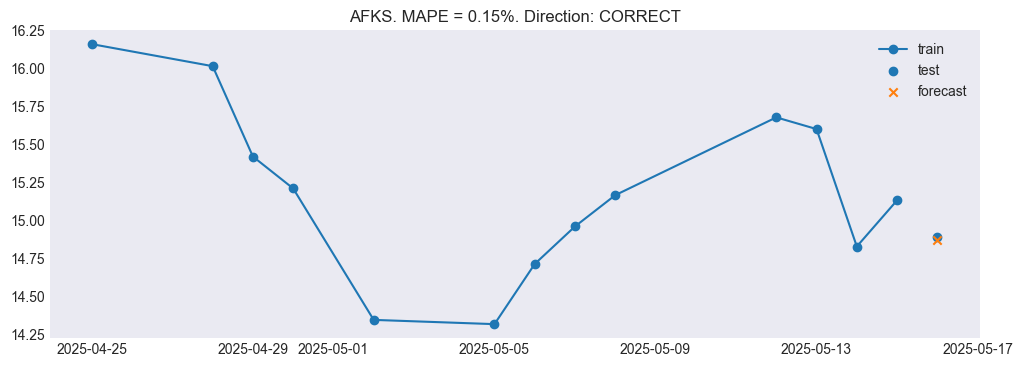

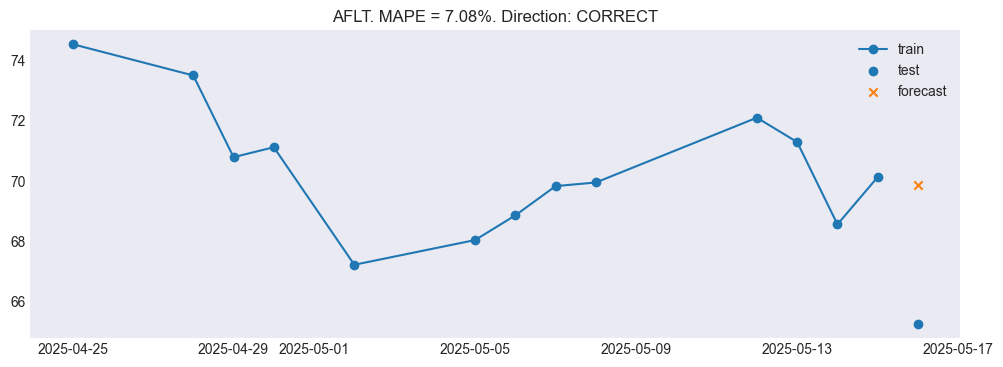

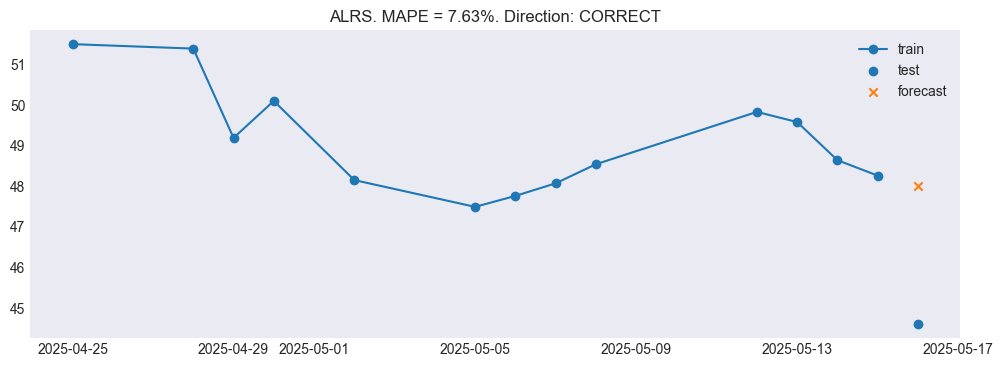

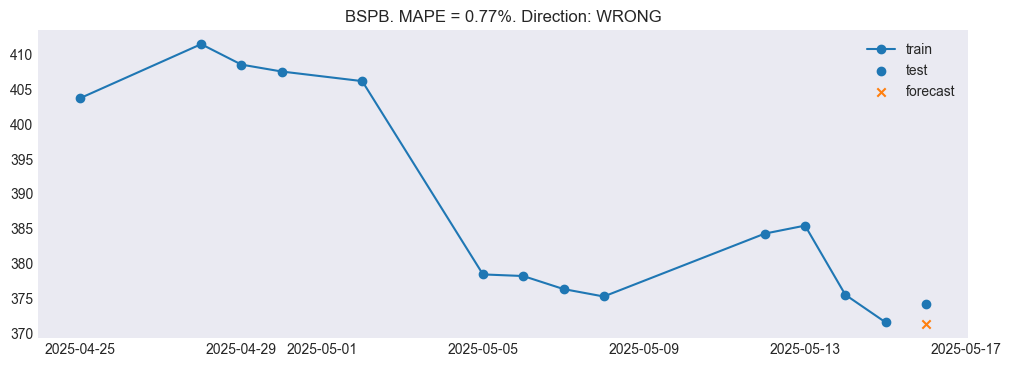

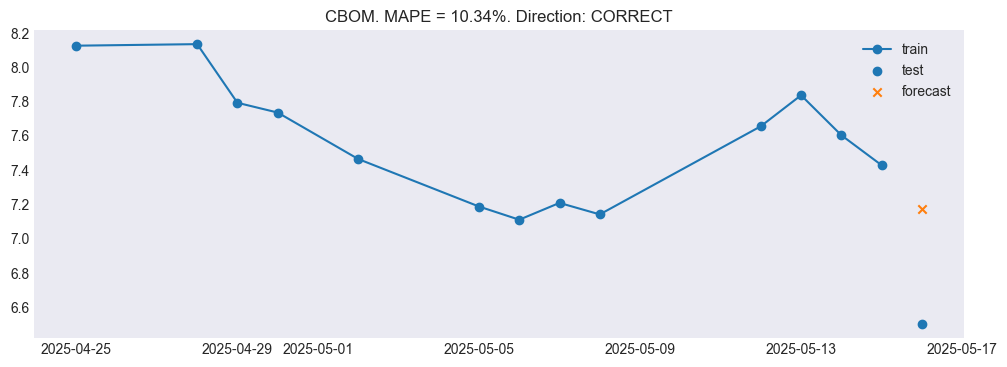

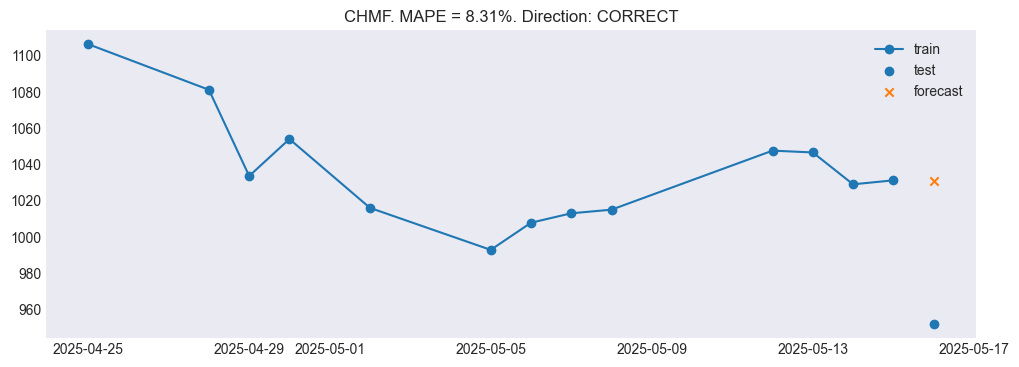

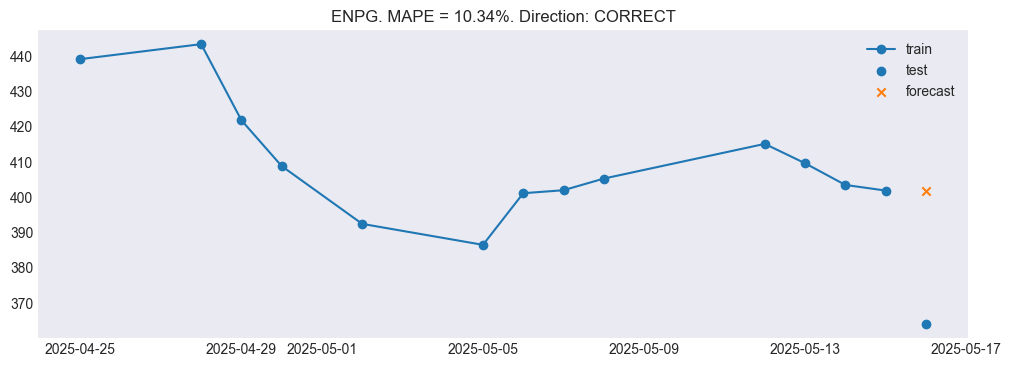

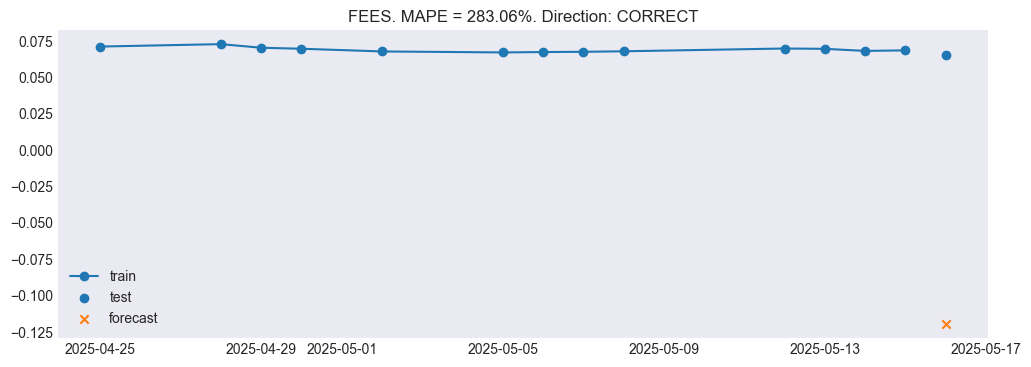

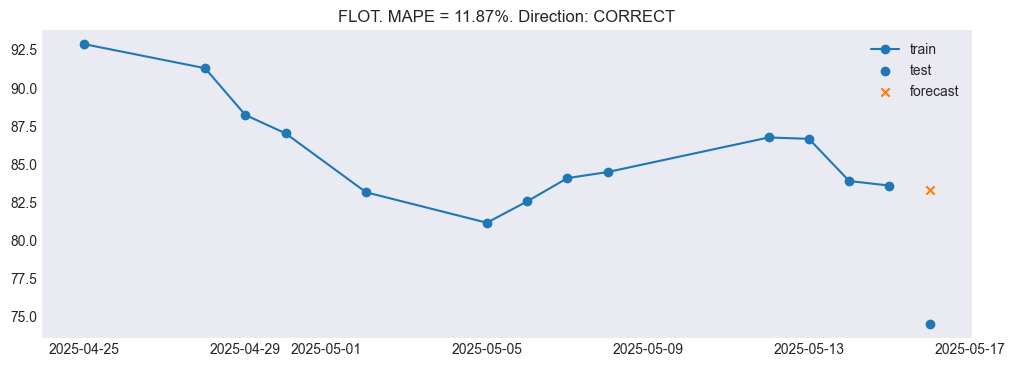

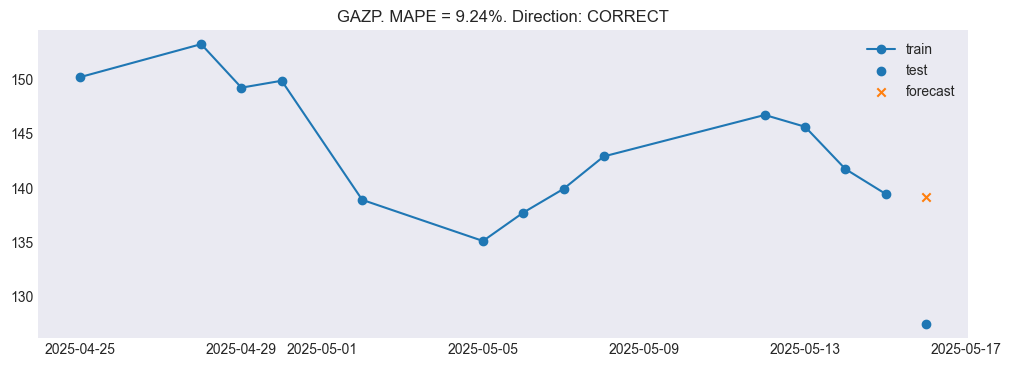

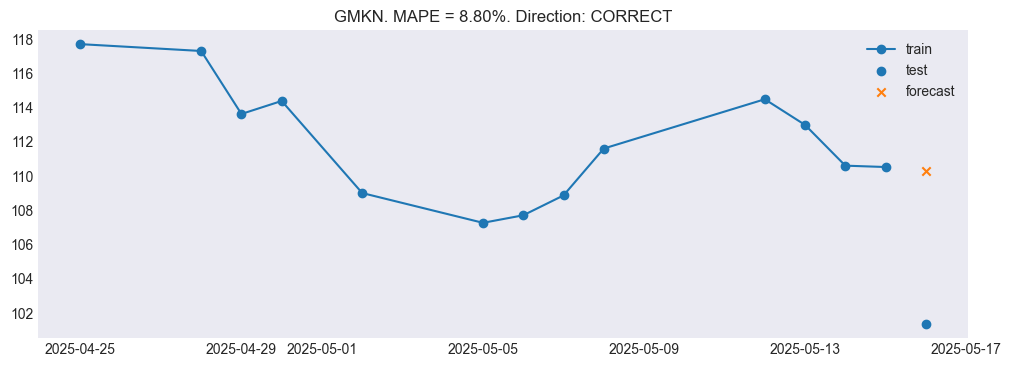

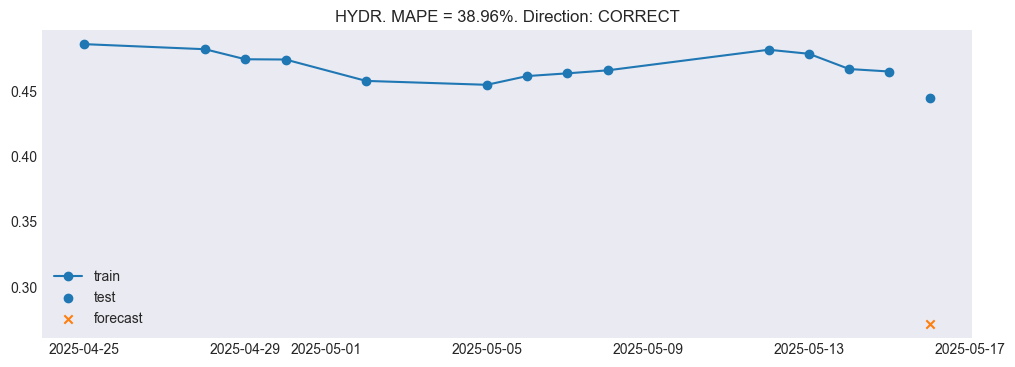

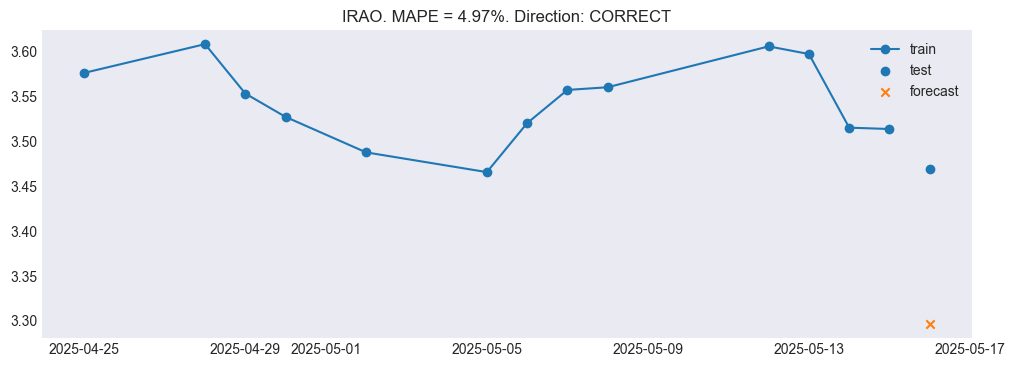

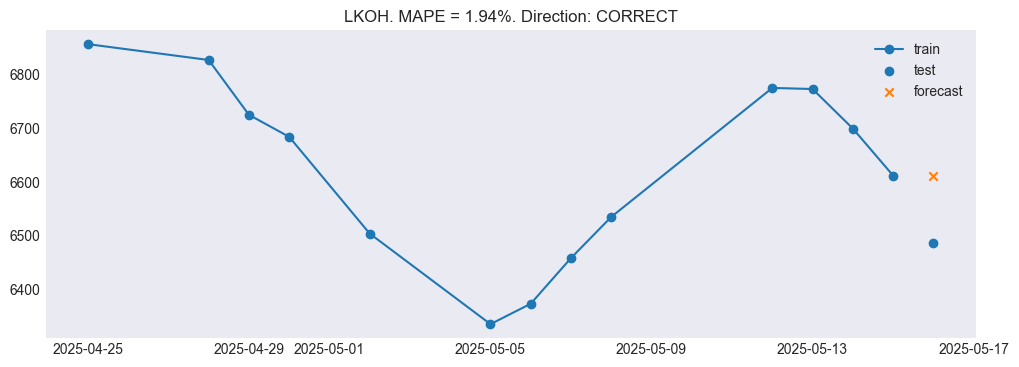

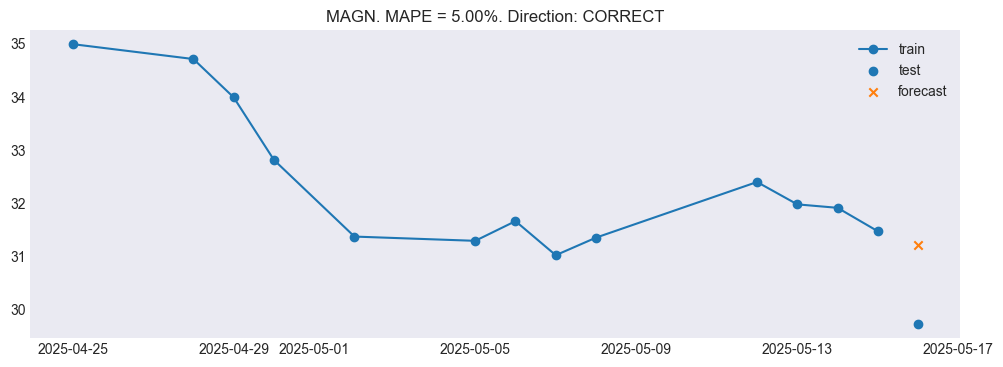

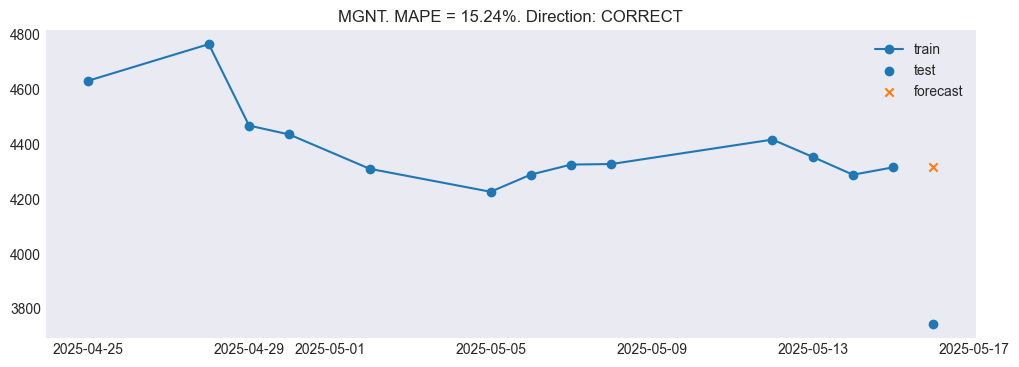

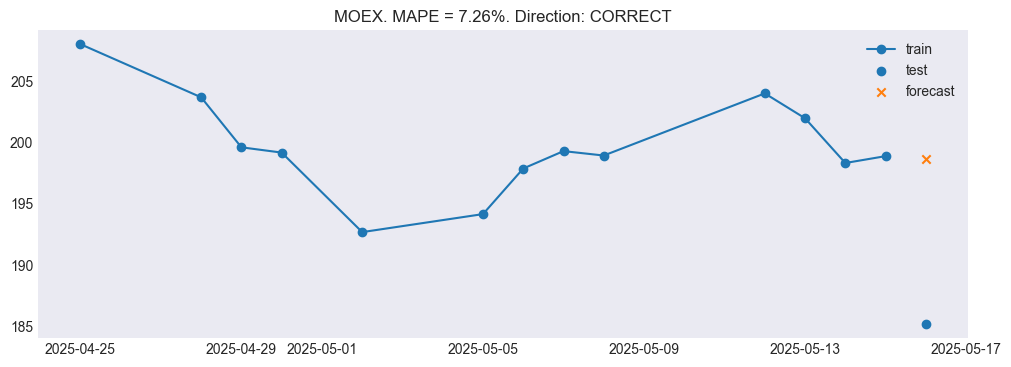

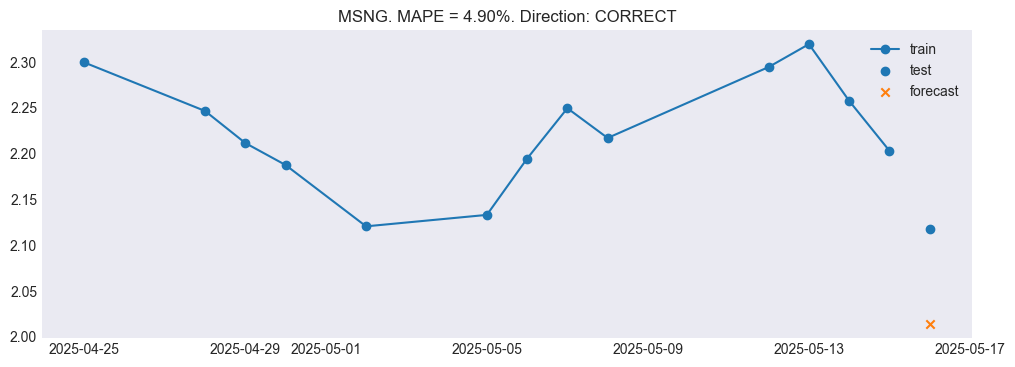

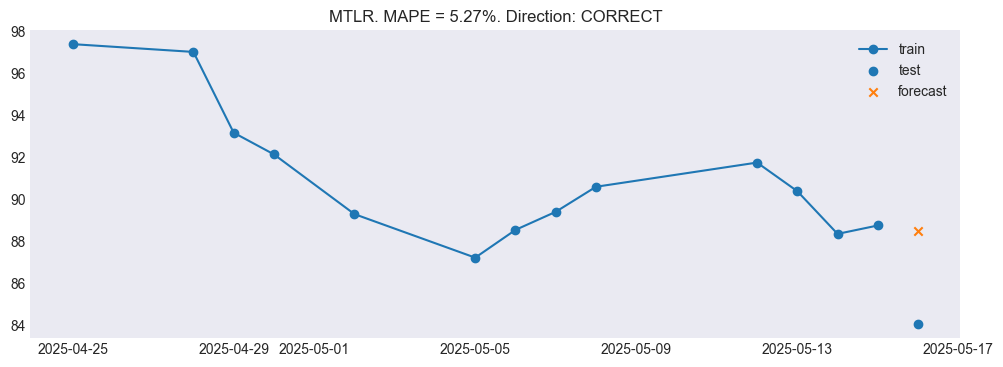

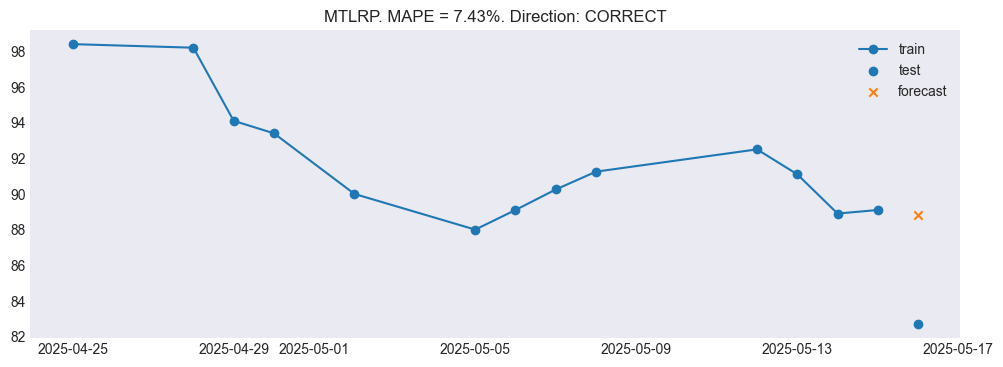

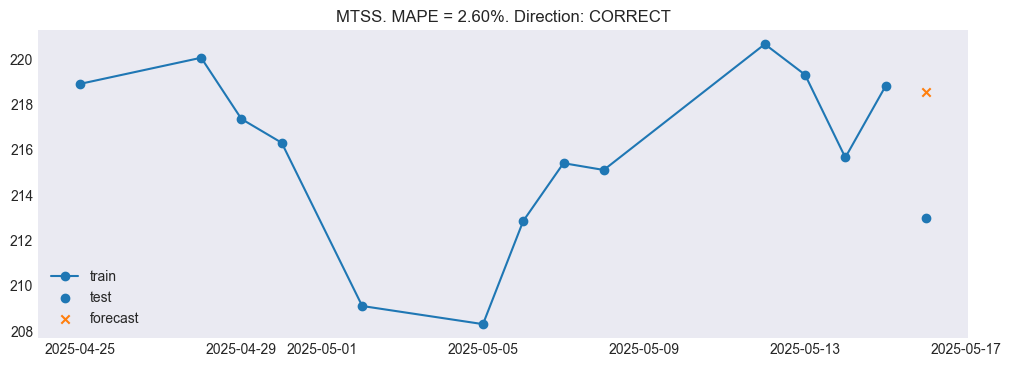

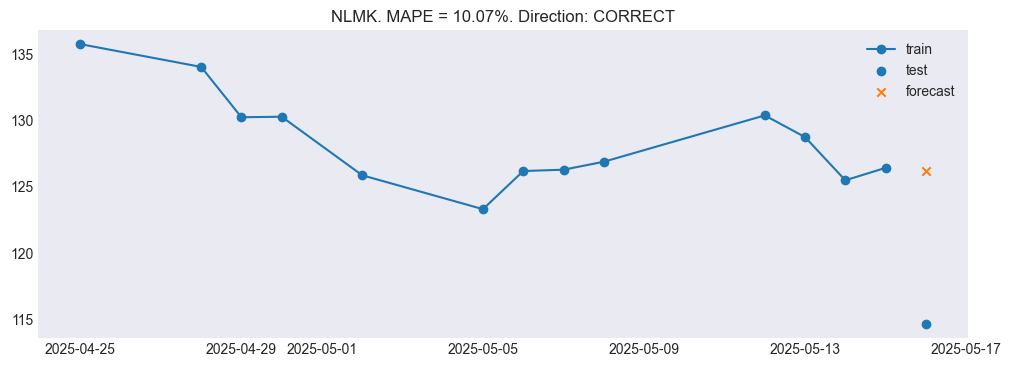

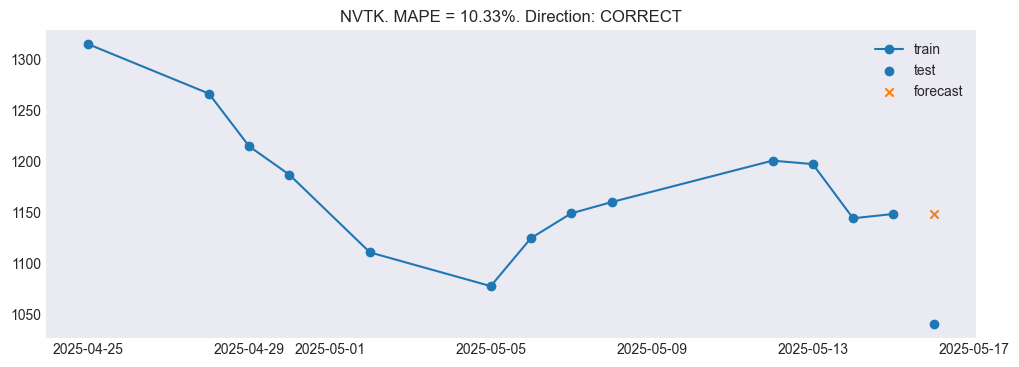

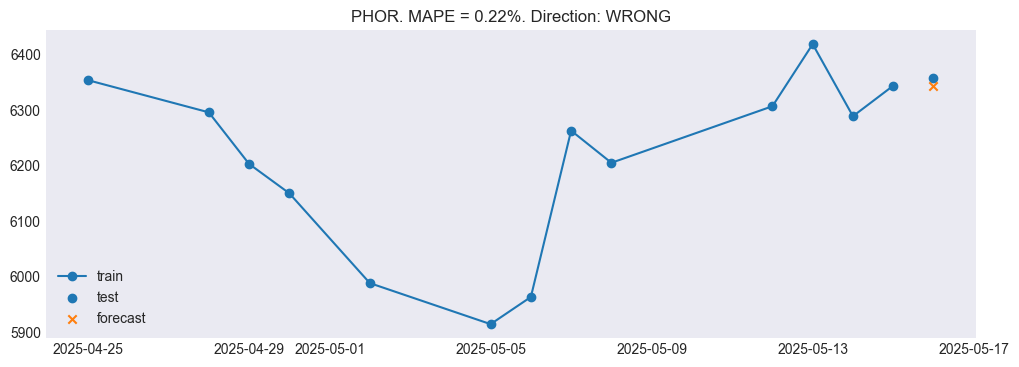

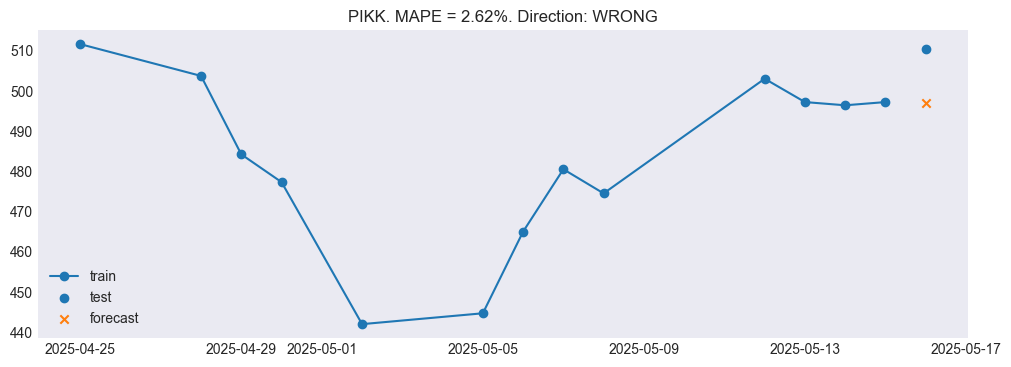

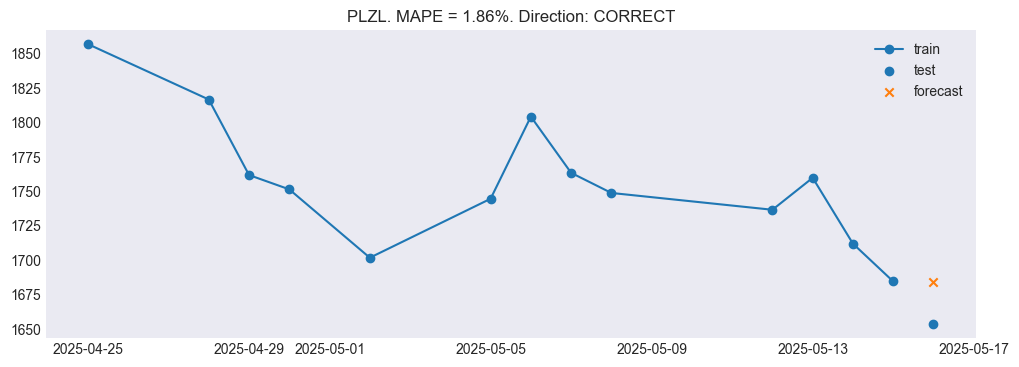

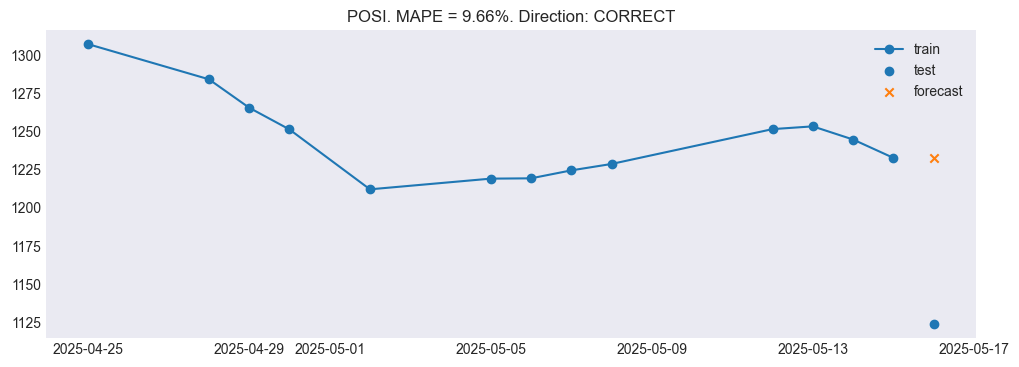

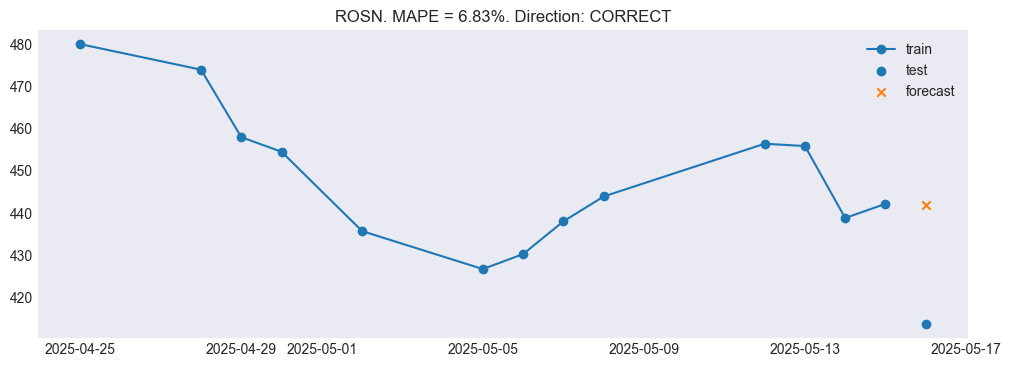

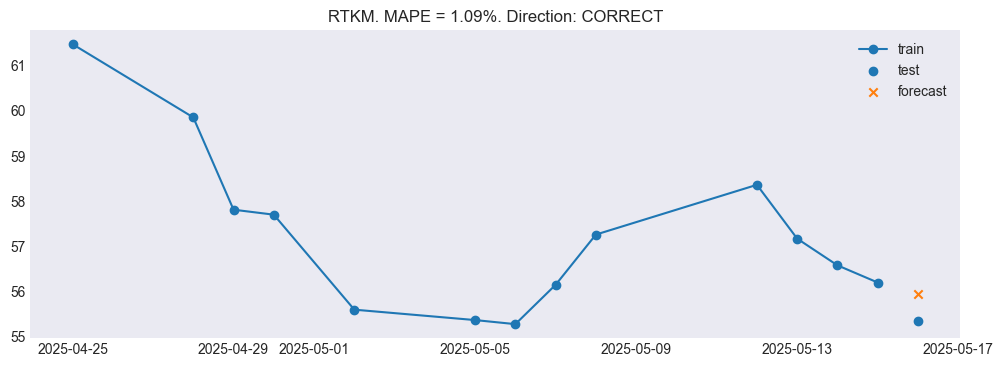

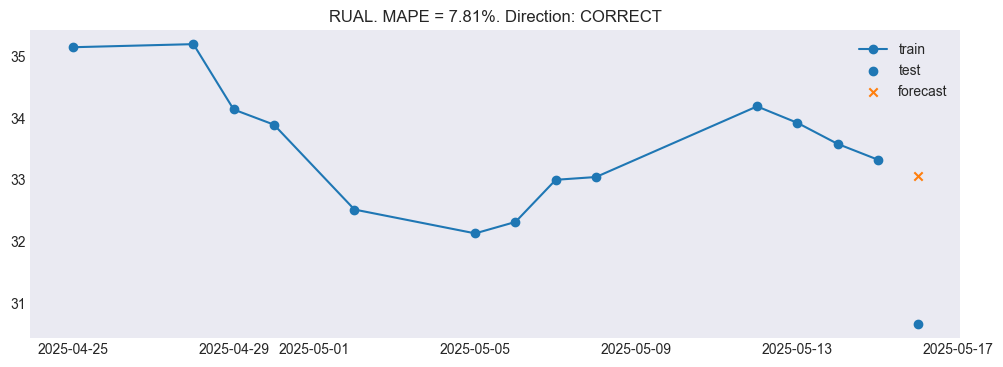

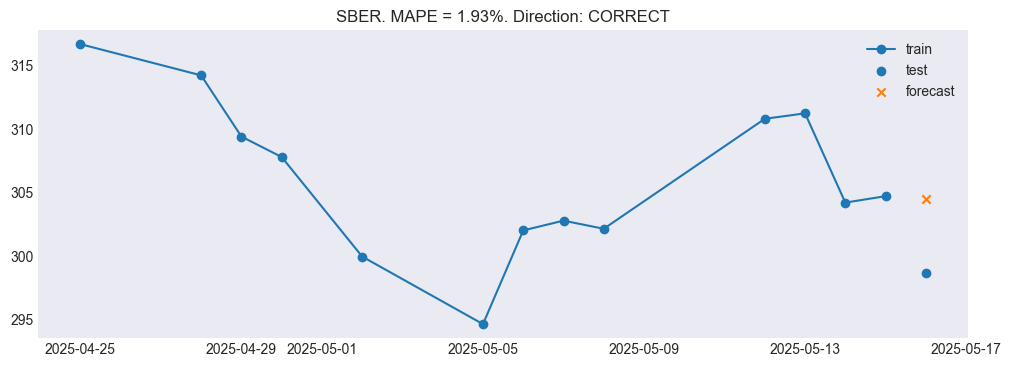

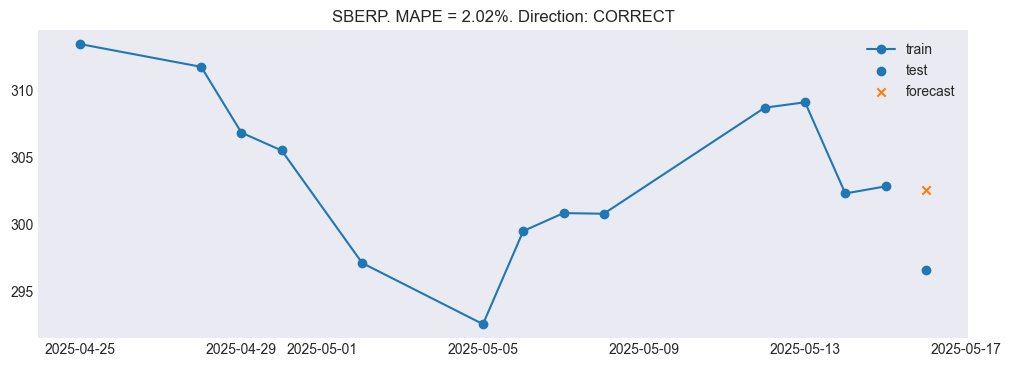

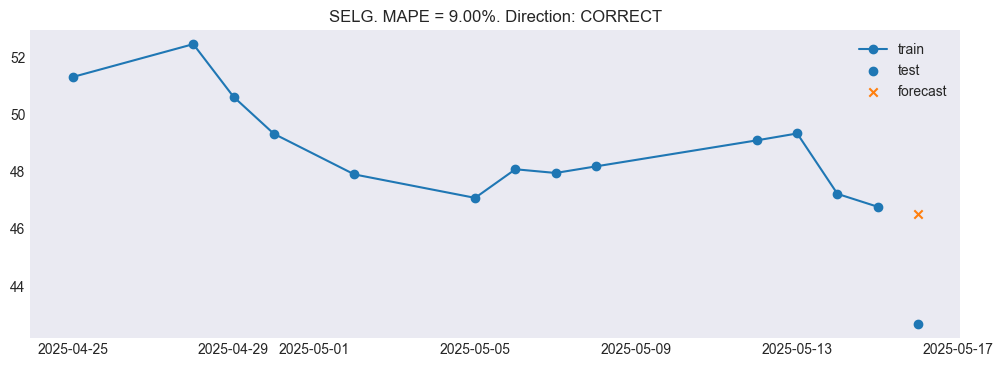

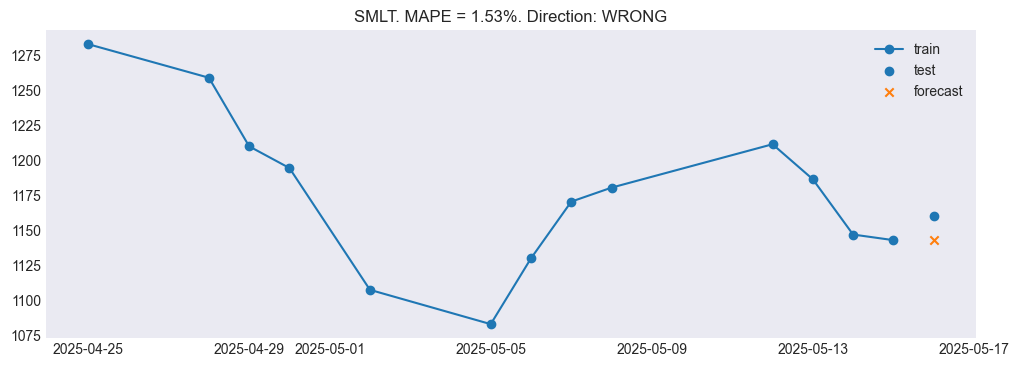

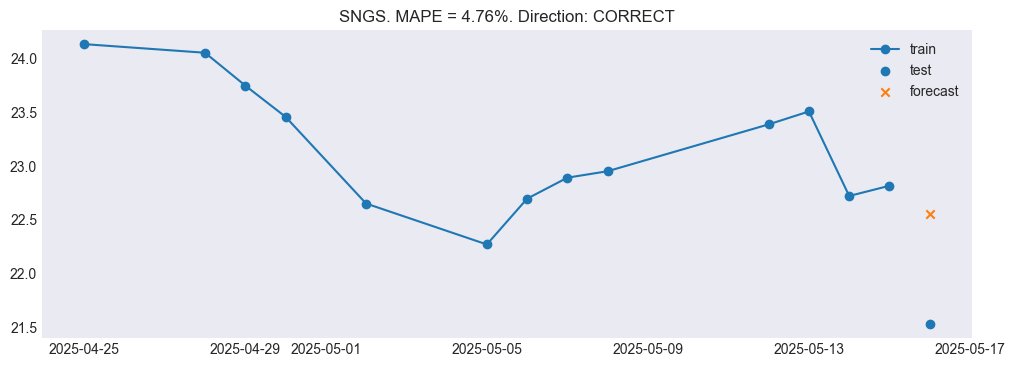

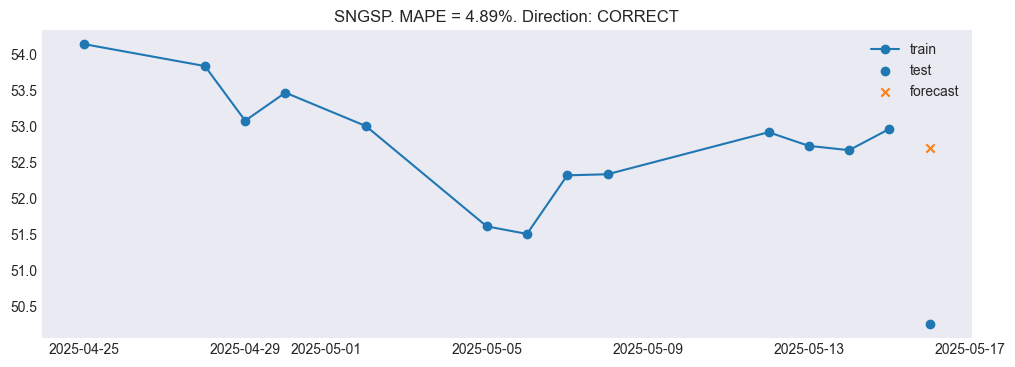

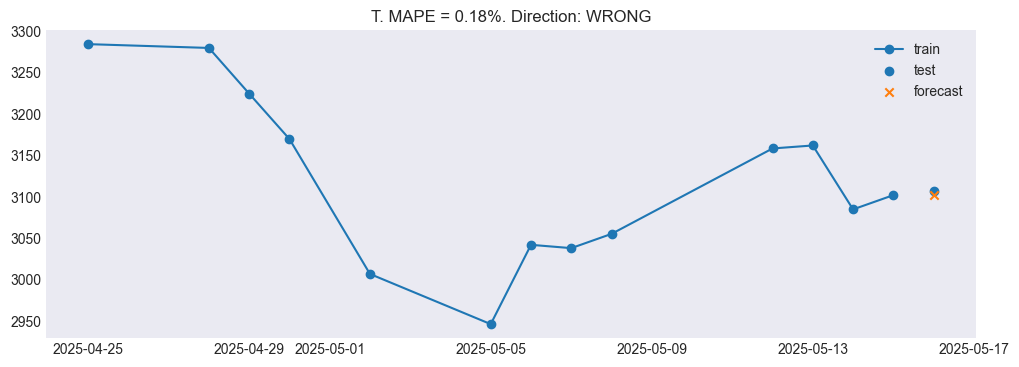

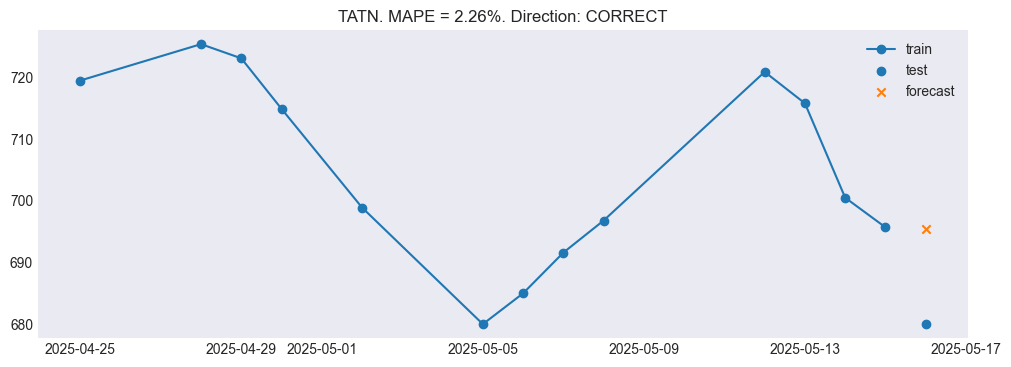

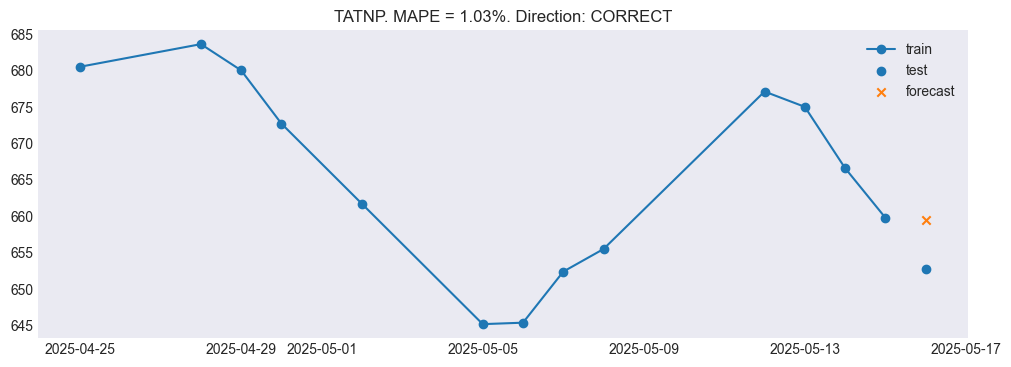

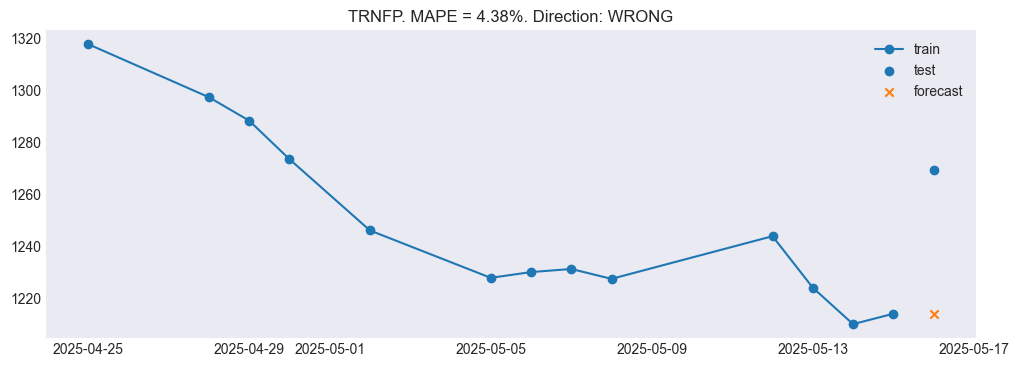

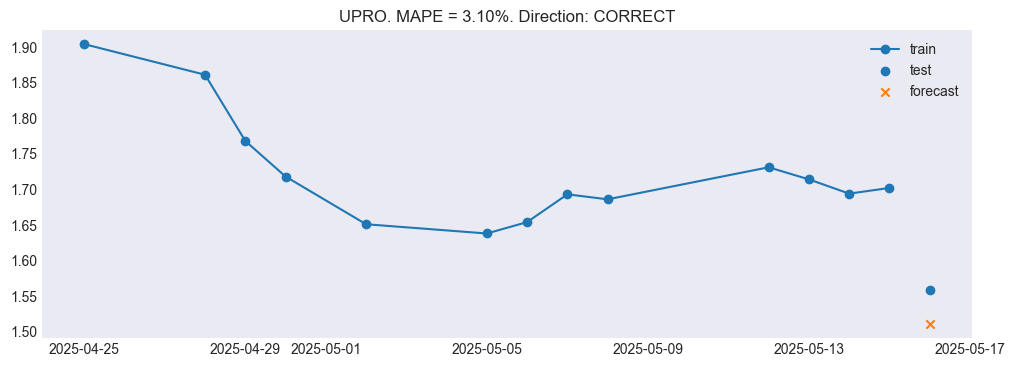

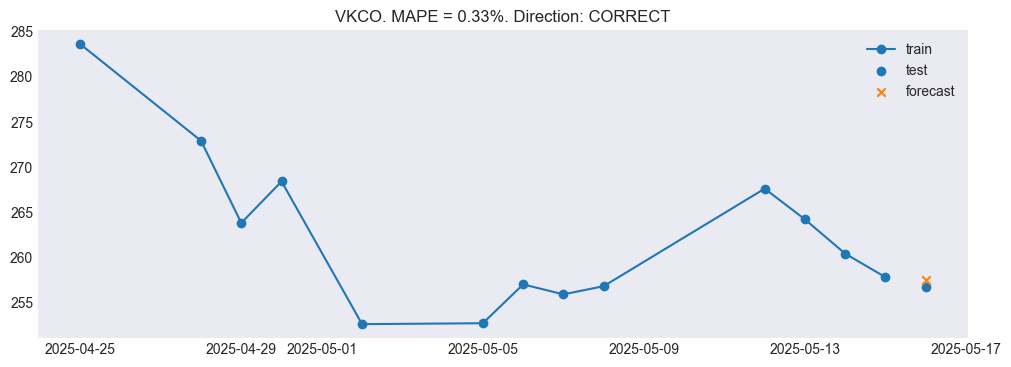

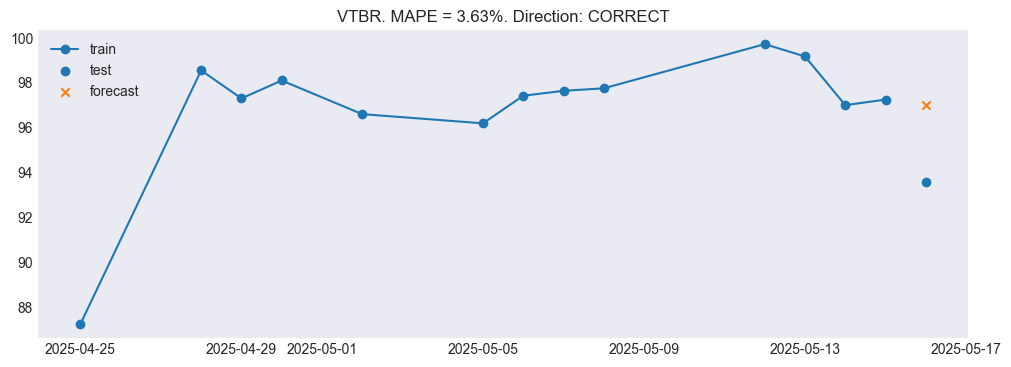

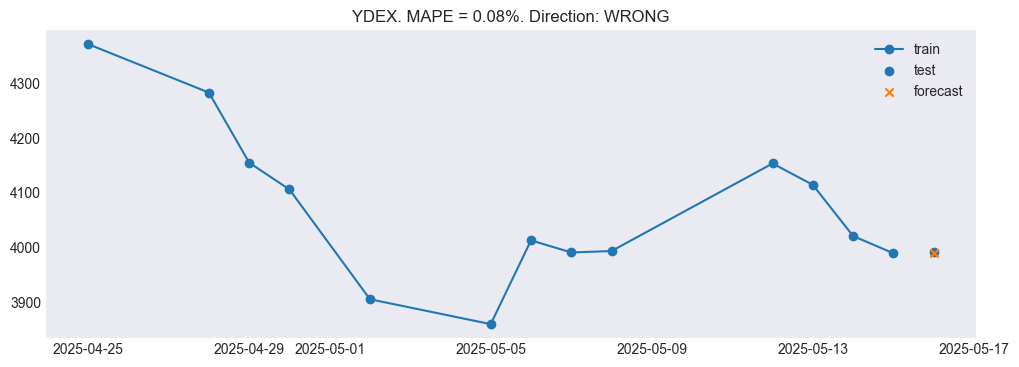

In [998]:
for ticker in df['SECID'].unique():
    plt.figure(figsize=(12, 4))
    
    row_ticker = concatted_mlf[(concatted_mlf['unique_id'] == ticker) & (concatted_mlf['ds'] >= concatted_mlf['ds'].max() + pd.Timedelta(days=-20))]
    row_forecasts = forecasts[forecasts['unique_id'] == ticker]
    row_test = df[(df['TRADEDATE'] == df['TRADEDATE'].max()) & (df['SECID'] == ticker)]

    forecast_point = row_forecasts['TimesNet'].values[0]
    test_point = row_test['CLOSE'].values[0]
    train_last_point = row_ticker['y'].values[-1]

    mape_err = (np.abs(row_forecasts['TimesNet'].values - row_test['CLOSE'].values) / row_test['CLOSE'].values)[0]
    direction_correct_flg = ( (forecast_point > train_last_point) == (test_point > train_last_point) )

    plt.title(f'{ticker}. MAPE = {mape_err:.2%}. Direction: {"CORRECT" if direction_correct_flg == 1 else "WRONG"}')
    plt.plot(row_ticker['ds'], row_ticker['y'], label='train', marker='o')
    plt.scatter(row_forecasts['ds'], row_test['CLOSE'], label='test')
    plt.scatter(row_forecasts['ds'], row_forecasts['TimesNet'], marker='x', label='forecast')

    plt.grid()
    plt.legend()

### Метрики

In [ ]:
for ticker in df['SECID'].unique():
    plt.figure(figsize=(12, 4))
    
    row_ticker = concatted_mlf[(concatted_mlf['unique_id'] == ticker) & (concatted_mlf['ds'] >= concatted_mlf['ds'].max() + pd.Timedelta(days=-20))]
    row_forecasts = forecasts[forecasts['unique_id'] == ticker]
    row_test = df[(df['TRADEDATE'] == df['TRADEDATE'].max()) & (df['SECID'] == ticker)]

    forecast_point = row_forecasts['TimesNet'].values[0]
    test_point = row_test['CLOSE'].values[0]
    train_last_point = row_ticker['y'].values[-1]

    mape_err = (np.abs(row_forecasts['TimesNet'].values - row_test['CLOSE'].values) / row_test['CLOSE'].values)[0]
    direction_correct_flg = ( (forecast_point > train_last_point) == (test_point > train_last_point) )

    plt.title(f'{ticker}. MAPE = {mape_err:.2%}. Direction: {"CORRECT" if direction_correct_flg == 1 else "WRONG"}')
    plt.plot(row_ticker['ds'], row_ticker['y'], label='train', marker='o')
    plt.scatter(row_forecasts['ds'], row_test['CLOSE'], label='test')
    plt.scatter(row_forecasts['ds'], row_forecasts['TimesNet'], marker='x', label='forecast')

    plt.grid()
    plt.legend()

In [957]:
last_train = concatted_mlf.loc[concatted_mlf['ds'] == concatted_mlf['ds'].max(), ['unique_id', 'y']].sort_values(by='unique_id')
forecast_test = forecasts.loc[:, ['unique_id', 'TimesNet']].sort_values(by='unique_id')
true_test = df.loc[(df['TRADEDATE'] == df['TRADEDATE'].max()), ['SECID', 'CLOSE']].sort_values(by='SECID')

avg_percentage_error = (np.abs(forecast_test['TimesNet'].values - true_test['CLOSE'].values) / np.abs(true_test['CLOSE'].values))
avg_percentage_error_mean = avg_percentage_error.mean()

directional_accuracy = ( (forecast_test['TimesNet'].values >= last_train['y'].values) == (true_test['CLOSE'].values >= last_train['y'].values) )
directional_accuracy_mean = directional_accuracy.mean()

by_share_table = pd.concat([forecast_test['unique_id'], 
                            pd.Series(avg_percentage_error * 100, name='MAPE').round(2).astype(str) + '%', 
                            pd.Series(directional_accuracy.astype(int), name='Guessed direction correctly?')],
                            axis=1)

avg_stats = pd.DataFrame({'MAPE': f'{avg_percentage_error_mean :.2%}',
                          'Directional_Accuracy': f'{directional_accuracy_mean :.2%}'},
                          index=['TimesNet'])

print(f'На данных {df["TRADEDATE"].max().date()} модель имеет следующие метрики качества предсказания:\n')
print('В разрезе по акциям:')
display(by_share_table)
print('\nВ среднем:')
display(avg_stats)

На данных 2025-05-16 модель имеет следующие метрики качества предсказания:

В разрезе по акциям:


unique_id     MAPE  Guessed direction correctly?
0       AFKS    0.34%                             1
1       AFLT    1.03%                             1
2       ALRS    0.52%                             1
3       BSPB    1.96%                             0
4       CBOM    1.83%                             1
5       CHMF    0.36%                             1
6       ENPG    0.81%                             1
7       FEES  273.81%                             0
8       FLOT    0.78%                             1
9       GAZP    0.06%                             1
10      GMKN    0.31%                             0
11      HYDR   41.64%                             1
12      IRAO    6.49%                             0
13      LKOH     0.1%                             1
14      MAGN    0.08%                             1
15      MGNT    1.18%                             1
16      MOEX    1.18%                             1
17      MSNG    7.65%                             1
18      MTLR    0.17%                             1
19     MTLRP    0.07%                             1
20      MTSS    0.92%                             1
21      NLMK    0.08%                             1
22      NVTK    0.14%                             0
23      PHOR    4.13%                             0
24      PIKK    2.84%                             1
25      PLZL    1.26%                             1
26      POSI    0.09%                             0
27      ROSN    0.46%                             1
28      RTKM    0.02%                             1
29      RUAL    0.82%                             1
30      SBER    0.61%                             0
31     SBERP    0.64%                             0
32      SELG    0.74%                             1
33      SMLT    0.77%                             1
34      SNGS    0.71%                             1
35     SNGSP    0.45%                             1
36         T    0.94%                             1
37      TATN    0.51%                             0
38     TATNP    0.58%                             0
39     TRNFP    0.41%                             1
40      UPRO   11.45%                             0
41      VKCO    0.49%                             0
42      VTBR     0.2%                             1
43      YDEX    0.81%                             0


В среднем:


MAPE Directional_Accuracy
TimesNet  8.42%               68.18%

In [992]:
concatted_mlf

unique_id         ds         y  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
49         AFKS 2022-06-16    12.695      12.461      12.550      12.450   
50         AFKS 2022-06-17    12.508      12.695      12.461      12.550   
51         AFKS 2022-06-20    12.830      12.508      12.695      12.461   
52         AFKS 2022-06-21    12.972      12.830      12.508      12.695   
53         AFKS 2022-06-22    12.900      12.972      12.830      12.508   
...         ...        ...       ...         ...         ...         ...   
34093      YDEX 2025-05-08  3993.500    3991.000    4013.000    3860.000   
34094      YDEX 2025-05-12  4153.500    3993.500    3991.000    4013.000   
34095      YDEX 2025-05-13  4114.500    4153.500    3993.500    3991.000   
34096      YDEX 2025-05-14  4021.000    4114.500    4153.500    3993.500   
34097      YDEX 2025-05-15  3989.500    4021.000    4114.500    4153.500   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
49         12.302      12.565      12.470      12.540  ...   
50         12.450      12.302      12.565      12.470  ...   
51         12.550      12.450      12.302      12.565  ...   
52         12.461      12.550      12.450      12.302  ...   
53         12.695      12.461      12.550      12.450  ...   
...           ...         ...         ...         ...  ...   
34093    3905.500    4106.000    4155.000    4283.000  ...   
34094    3860.000    3905.500    4106.000    4155.000  ...   
34095    4013.000    3860.000    3905.500    4106.000  ...   
34096    3991.000    4013.000    3860.000    3905.500  ...   
34097    3993.500    3991.000    4013.000    3860.000  ...   

       moving_average_short  moving_average_long  bollinger_upper  \
49                  12.7172             12.76714        13.241743   
50                  12.6751             12.73950        13.118633   
51                  12.6786             12.71400        13.125847   
52                  12.7066             12.70442        13.153697   
53                  12.7216             12.69256        13.173489   
...                     ...                  ...              ...   
34093             4158.3750           4334.31000      4448.335838   
34094             4162.8250           4329.84000      4449.600744   
34095             4159.7500           4323.67000      4447.212780   
34096             4154.8250           4317.14000      4448.191882   
34097             4144.6500           4305.21000      4446.021880   

       bollinger_lower    stoch_k    stoch_d         atr        adx  \
49           12.192657  55.405405  44.024024    0.469477  14.103937   
50           12.231567  38.558559  42.762763    0.452586  14.087248   
51           12.231353  67.567568  53.843844    0.455401  14.721709   
52           12.259503  80.360360  62.162162    0.439301  15.310852   
53           12.269711  73.873874  73.933934    0.440136  15.312309   
...                ...        ...        ...         ...        ...   
34093      3868.414162  30.449534  31.410800  161.516957  31.191523   
34094      3876.049256  57.591179  39.355386  164.015746  30.042667   
34095      3872.287220  50.975403  46.338705  160.014621  28.975872   
34096      3861.458118  36.443662  48.336748  158.085005  28.348586   
34097      3843.278120  31.339286  39.586117  156.543219  28.383813   

       williams_r        cci  
49     -44.594595 -27.967641  
50     -61.441441 -35.663787  
51     -32.432432  44.520739  
52     -19.639640  83.163072  
53     -26.126126  60.583060  
...           ...        ...  
34093  -69.550466 -89.463001  
34094  -42.408821 -31.134743  
34095  -49.024597 -23.471627  
34096  -63.556338 -52.520816  
34097  -68.660714 -84.567274  

[32692 rows x 33 columns]

In [994]:
df

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
49    2022-06-16  AFKS    12.601    12.510    12.695    12.441    12.748   
50    2022-06-17  AFKS    12.611    12.700    12.508    12.508    12.741   
51    2022-06-20  AFKS    12.833    12.549    12.830    12.522    13.000   
52    2022-06-21  AFKS    12.904    12.990    12.972    12.760    12.990   
53    2022-06-22  AFKS    12.767    12.975    12.900    12.620    13.071   
...          ...   ...       ...       ...       ...       ...       ...   
35195 2025-05-21  YDEX  4009.000  4042.000  3990.500  3971.000  4050.000   
35196 2025-05-22  YDEX  3997.500  3980.500  4024.000  3925.000  4089.000   
35197 2025-05-23  YDEX  4016.500  4029.500  4009.500  3996.000  4048.000   
35198 2025-05-26  YDEX  3934.000  4004.000  3917.000  3886.000  4024.000   
35199 2025-05-27  YDEX  3969.500  3917.000  3992.500  3855.000  4024.000   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  moving_average_short  \
49     24067400.0      12.461      12.550  ...               12.7172   
50      9084900.0      12.695      12.461  ...               12.6751   
51     35341000.0      12.508      12.695  ...               12.6786   
52     23216000.0      12.830      12.508  ...               12.7066   
53     23391800.0      12.972      12.830  ...               12.7216   
...           ...         ...         ...  ...                   ...   
35195    308142.0    4040.500    4054.000  ...             4100.2250   
35196    773529.0    3990.500    4040.500  ...             4083.3000   
35197    335528.0    4024.000    3990.500  ...             4069.5250   
35198    505249.0    4009.500    4024.000  ...             4050.7250   
35199    694981.0    3917.000    4009.500  ...             4031.7750   

       moving_average_long  bollinger_upper  bollinger_lower    stoch_k  \
49                12.76714        13.241743        12.192657  55.405405   
50                12.73950        13.118633        12.231567  38.558559   
51                12.71400        13.125847        12.231353  67.567568   
52                12.70442        13.153697        12.259503  80.360360   
53                12.69256        13.173489        12.269711  73.873874   
...                    ...              ...              ...        ...   
35195           4264.83000      4390.782477      3809.667523  44.458438   
35196           4254.02000      4349.161317      3817.438683  55.851064   
35197           4243.63000      4320.275768      3818.774232  51.994681   
35198           4232.37000      4287.635843      3813.814157  26.809651   
35199           4221.68000      4218.293223      3845.256777  41.044776   

         stoch_d         atr        adx  williams_r        cci  
49     44.024024    0.469477  14.103937  -44.594595 -27.967641  
50     42.762763    0.452586  14.087248  -61.441441 -35.663787  
51     53.843844    0.455401  14.721709  -32.432432  44.520739  
52     62.162162    0.439301  15.310852  -19.639640  83.163072  
53     73.933934    0.440136  15.312309  -26.126126  60.583060  
...          ...         ...        ...         ...        ...  
35195  44.550237  142.320502  27.381767  -55.541562 -59.682512  
35196  48.461376  143.869037  27.610998  -44.148936 -49.657297  
35197  50.768061  137.306963  27.823856  -48.005319 -41.886977  
35198  44.885132  137.356466  28.727334  -73.190349 -92.615381  
35199  39.949703  139.616718  29.742388  -58.955224 -78.458925  

[33044 rows x 38 columns]

In [995]:
dct_for_dates

{Timestamp('2022-06-16 00:00:00'): Timestamp('2022-06-16 00:00:00'),
 Timestamp('2022-06-17 00:00:00'): Timestamp('2022-06-17 00:00:00'),
 Timestamp('2022-06-18 00:00:00'): Timestamp('2022-06-20 00:00:00'),
 Timestamp('2022-06-19 00:00:00'): Timestamp('2022-06-21 00:00:00'),
 Timestamp('2022-06-20 00:00:00'): Timestamp('2022-06-22 00:00:00'),
 Timestamp('2022-06-21 00:00:00'): Timestamp('2022-06-23 00:00:00'),
 Timestamp('2022-06-22 00:00:00'): Timestamp('2022-06-24 00:00:00'),
 Timestamp('2022-06-23 00:00:00'): Timestamp('2022-06-27 00:00:00'),
 Timestamp('2022-06-24 00:00:00'): Timestamp('2022-06-28 00:00:00'),
 Timestamp('2022-06-25 00:00:00'): Timestamp('2022-06-29 00:00:00'),
 Timestamp('2022-06-26 00:00:00'): Timestamp('2022-06-30 00:00:00'),
 Timestamp('2022-06-27 00:00:00'): Timestamp('2022-07-01 00:00:00'),
 Timestamp('2022-06-28 00:00:00'): Timestamp('2022-07-04 00:00:00'),
 Timestamp('2022-06-29 00:00:00'): Timestamp('2022-07-05 00:00:00'),
 Timestamp('2022-06-30 00:00:00'):